<a href="https://colab.research.google.com/github/viniventur/previsao_artigo_HW_SARIMA/blob/main/SARIMA_artigo_hw_sarima_anpec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo de previsão de receitas utilizando SARIMA para os ICMS e IPVA

# Librarys utilizadas

In [271]:
!pip install pmdarima arch -q

In [269]:
import pandas as pd
import numpy as np
import scipy
import pmdarima as pm
import itertools
from itertools import product
from google.colab import drive
drive.mount('/content/drive')
import statsmodels.api as sm
import os
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
import matplotlib as mpl
import matplotlib.ticker as mticker
from datetime import datetime
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import seaborn as sns
import warnings
import arch
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

# Previsão
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot
from scipy import stats
from scipy.stats import boxcox

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.forecasting.stl import STLForecast

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tratando dados

In [3]:
df = pd.read_excel("/content/drive/MyDrive/Gerência de Estudos e Projeções/Dados/Impostos/Impostos - ICMS - ITCD - IPVA - IRRF - 1999 - 2024.xlsx", sheet_name='dados_1999_2024')
df['Total'] = df.ICMS + df.IPVA + df.IRRF + df.ITCD
df

ANO  MES          ICMS         IPVA        ITCD          IRRF  \
0    1999    1  4.035843e+07    658956.65    21163.97  3.293230e+03   
1    1999    2  3.894808e+07   1032605.36    13089.30  8.150040e+03   
2    1999    3  3.194334e+07   2489990.52    26279.08  0.000000e+00   
3    1999    4  3.415198e+07   1851256.22    42705.30  0.000000e+00   
4    1999    5  3.282836e+07   1905139.44    27892.99  0.000000e+00   
..    ...  ...           ...          ...         ...           ...   
302  2024    3  6.412978e+08  46837316.37  3990607.28  7.723583e+07   
303  2024    4  6.901577e+08  64609203.08  4789282.70  8.712705e+07   
304  2024    5  6.356771e+08  73725244.53  4528985.51  9.139155e+07   
305  2024    6  6.307851e+08  71891371.15  5737256.86  1.084689e+08   
306  2024    7  5.003486e+05   1572304.84         NaN  1.079842e+05   

            Total  
0    4.104184e+07  
1    4.000192e+07  
2    3.445961e+07  
3    3.604594e+07  
4    3.476139e+07  
..            ...  
302  7.693616e+08  
303  8.466832e+08  
304  8.053229e+08  
305  8.168826e+08  
306           NaN  

[307 rows x 7 columns]

In [4]:
# Limpando a base
df.dropna(inplace=True)
df['Data'] = pd.to_datetime(df['ANO'].astype(str) + '-' + df['MES'].astype(str))
df = df.set_index("Data")
df = df.drop(['MES', 'ANO'], axis=1)
df = df.loc[(df.index >= '2008-01-01') & (df.index <= '2023-12-01')] # inicio definido em 01-2008 e fim definido em 12-2023
df

ICMS         IPVA        ITCD          IRRF         Total
Data                                                                         
2008-01-01  1.435041e+08   3089289.71   272955.72  4.840761e+05  1.473504e+08
2008-02-01  1.339496e+08   4518615.04   110671.20  8.355140e+06  1.469340e+08
2008-03-01  1.263094e+08   6134471.17   215239.97  1.906390e+07  1.517230e+08
2008-04-01  1.245758e+08   8201420.84   207046.89  1.104372e+07  1.440280e+08
2008-05-01  1.288502e+08   8670808.35   239724.30  1.093729e+07  1.486980e+08
...                  ...          ...         ...           ...           ...
2023-08-01  5.578557e+08  56001603.14  4855889.47  5.354547e+07  6.722587e+08
2023-09-01  5.642487e+08  41140989.16  3953284.60  9.360826e+07  7.029513e+08
2023-10-01  5.865288e+08  37133784.15  5590517.01  7.255622e+07  7.018094e+08
2023-11-01  6.235283e+08  25042842.97  6630834.32  6.813230e+07  7.233343e+08
2023-12-01  8.145125e+08  19613082.86  7677496.60  1.517752e+08  9.935782e+08

[192 rows x 5 columns]

In [5]:
df = df[['ICMS', 'IPVA']]
df

ICMS         IPVA
Data                                 
2008-01-01  1.435041e+08   3089289.71
2008-02-01  1.339496e+08   4518615.04
2008-03-01  1.263094e+08   6134471.17
2008-04-01  1.245758e+08   8201420.84
2008-05-01  1.288502e+08   8670808.35
...                  ...          ...
2023-08-01  5.578557e+08  56001603.14
2023-09-01  5.642487e+08  41140989.16
2023-10-01  5.865288e+08  37133784.15
2023-11-01  6.235283e+08  25042842.97
2023-12-01  8.145125e+08  19613082.86

[192 rows x 2 columns]

In [245]:
# treino e real
df_treino = df.loc[(df.index >= '2008-01-01') & (df.index <= '2022-08-01')]
df_real = df.loc[(df.index >= '2022-09-01')]

In [246]:
df_icms = df['ICMS']
df_ipva = df['IPVA']

# Visualizando as séries

In [8]:
df_mm = df.copy()
for i in [6, 12]:
  for j in ['ICMS', 'IPVA']:
   df_mm[f'MM {i} - {j}'] = df_mm[j].rolling(i).mean()
df_mm.dropna(inplace=True)
df_mm

ICMS         IPVA   MM 6 - ICMS   MM 6 - IPVA  \
Data                                                                
2008-12-01  1.870634e+08   2929893.99  1.457239e+08  8.229485e+06   
2009-01-01  1.537090e+08   2810935.45  1.493781e+08  7.173771e+06   
2009-02-01  1.406116e+08   6221179.41  1.503702e+08  5.576891e+06   
2009-03-01  1.309832e+08   7423348.33  1.519977e+08  5.353430e+06   
2009-04-01  1.406609e+08   9078172.40  1.508689e+08  5.501070e+06   
...                  ...          ...           ...           ...   
2023-08-01  5.578557e+08  56001603.14  5.362222e+08  6.329400e+07   
2023-09-01  5.642487e+08  41140989.16  5.482573e+08  6.129938e+07   
2023-10-01  5.865288e+08  37133784.15  5.586703e+08  5.890352e+07   
2023-11-01  6.235283e+08  25042842.97  5.730940e+08  5.054158e+07   
2023-12-01  8.145125e+08  19613082.86  6.165103e+08  4.116977e+07   

            MM 12 - ICMS  MM 12 - IPVA  
Data                                    
2008-12-01  1.375538e+08  7.420653e+06  
2009-01-01  1.384042e+08  7.397457e+06  
2009-02-01  1.389594e+08  7.539337e+06  
2009-03-01  1.393489e+08  7.646744e+06  
2009-04-01  1.406893e+08  7.719806e+06  
...                  ...           ...  
2023-08-01  5.157865e+08  5.035843e+07  
2023-09-01  5.251690e+08  5.090509e+07  
2023-10-01  5.330926e+08  5.166462e+07  
2023-11-01  5.433235e+08  5.213117e+07  
2023-12-01  5.680574e+08  5.239386e+07  

[181 rows x 6 columns]

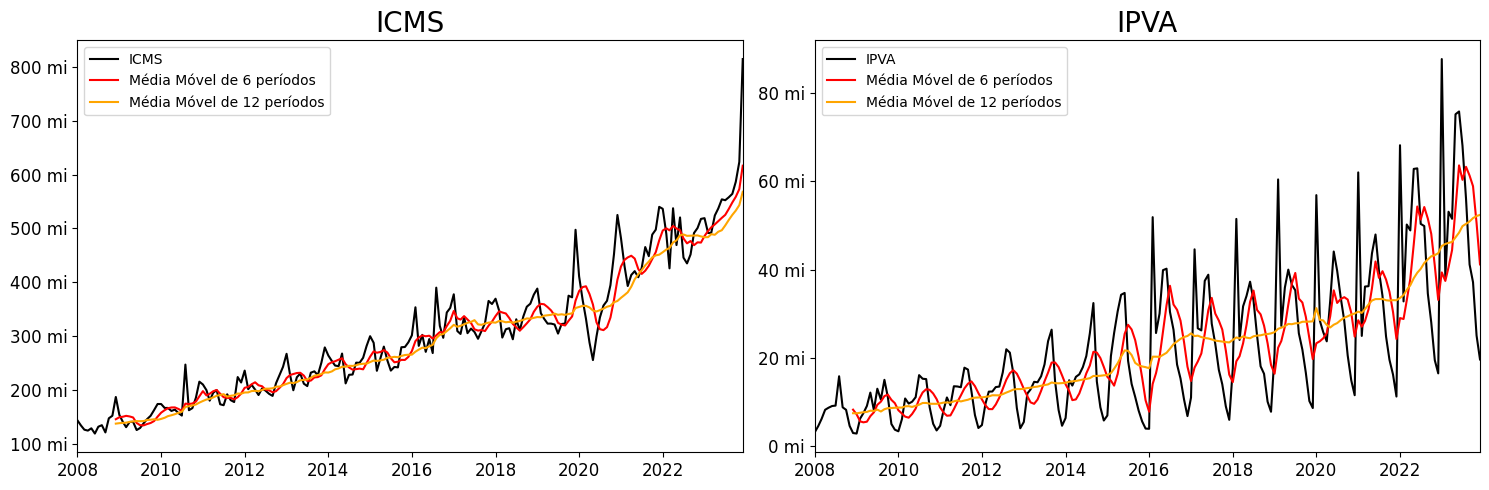

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Base de dados para os graficos
ini_treino = '2021-01-01'
fim_treino = '2022-08-01'
ini_prev = '2022-09-01'
fim_prev = '2023-12-01'
imp_ax = {'ICMS': ax1, 'IPVA': ax2}
cores_e_mm = {'red': 6, 'orange': 12}

for imp, axs in imp_ax.items():
  # Imposto
  sns.lineplot(x=df.loc[df.index <= fim_prev].index,
               y=df.loc[df.index <= fim_prev][imp],
               label=imp,
               color='black',
               ax=axs)
  # Médias móveis
  for c, i in cores_e_mm.items():
    sns.lineplot(x=df_mm.index,
                  y=df_mm[f'MM {i} - {imp}'],
                  color = c,
                  ax=axs,
                  linewidth=1.5,
                  label=f'Média Móvel de {i} períodos')

# Formatação
def formatar_milhares(x, pos):
  return f'{x/1000000:.0f} mi'
formatter = mticker.FuncFormatter(formatar_milhares)
year_locator = YearLocator(base=2)

for ax in (ax1, ax2):
  ax.xaxis.set_major_locator(year_locator)
  ax.yaxis.set_major_formatter(formatter)
  ax.set_xlabel('')
  ax.set_ylabel('')
  #ax.spines['top'].set_visible(False)
  #ax.spines['right'].set_visible(False)
  ax.set_xlim(min(df.index), max(df.loc[(df.index <= fim_prev)].index))
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)
  ax.legend(loc='upper left')
ax1.set_title('ICMS', fontdict={'fontsize': 20})
ax2.set_title('IPVA', fontdict={'fontsize': 20})
plt.tight_layout()
plt.show()

# Análise com metodologia box-jenkins

Para realizar a previsão com o (S)ARIMA, precisa-se do entendimento prévio de que a metodologia precisa contemplar a estacionariedade da série. Para isso, a análise gráfica da série possibilita esta visualização, e posteriormente os testes de Dickey Fuller Aumentado e KPSS atestarão a hipótese.

## ICMS


Escolha ótima de defasagens da série \
Critérios de seleção de defasagens para séries temporais
Akaike, Hannekin <- a escolha é do pesquisador. (1, 2, 3, no máximo 4 defasagens)
balizar a escolha de defasagens pelo critério de seleção.
1. Se a série não é muito longa, determinar menos defasagens



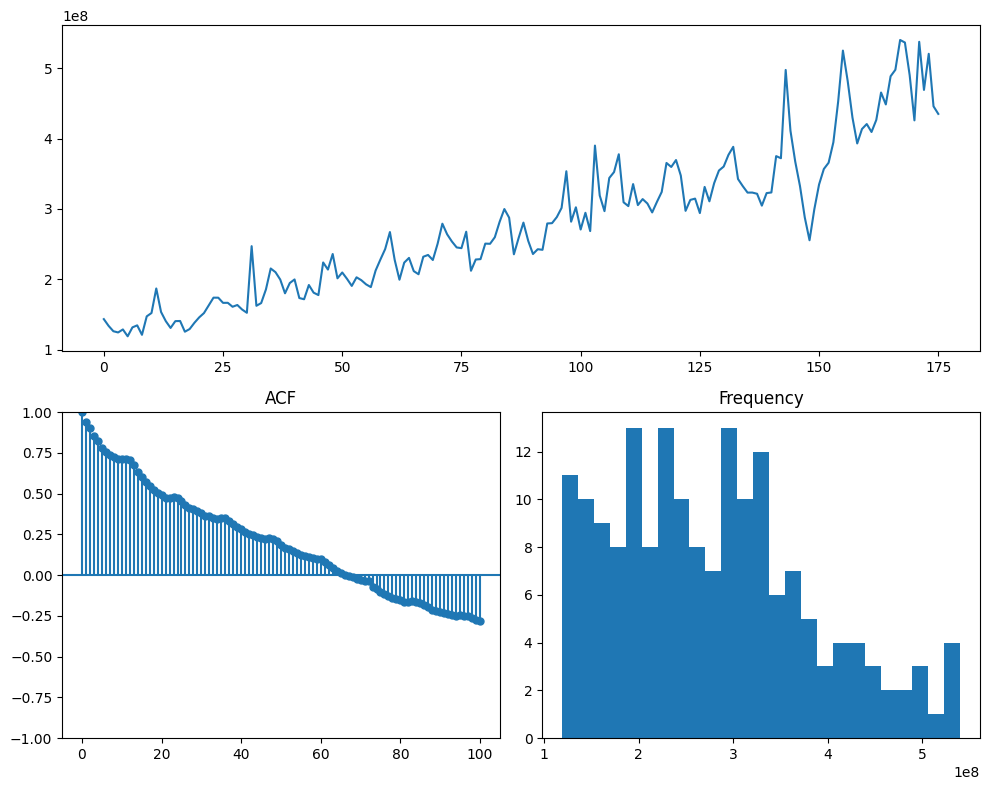

In [10]:
tsdisplay(df_treino['ICMS'], lag_max = 100, figsize = (10,8))

Analisando o gráfico plotado pelo comando _tsdisplay_, podemos observar três pontos importantes:
1. O gráfico da série;
2. O gráfico de autocorrelação da série;
3. E o histograma dos valores da série.

Aqui, o histograma não apresentam a aparência de uma distribuição normal, contudo realizaremos os procedimentos do método de Box-Jenkins para testar o modelo.
Vale a análise do gráfico de autocorrelação, o qual decresce lenta e continuamente, indicando a presença de raiz unitária na série.
Assim, serão realizados os testes de Dickey-Fuller Aumentado, KPSS e Phillips-Perron para identificar se a série é estacionária ou não.

In [11]:
teste_adf_icms = adfuller(df_treino['ICMS'], regression = 'c')
print('Estatística ADF - Constante: %f' %teste_adf_icms[0])
print('p-valor: %f' %teste_adf_icms[1])
print('=-----------------------------------=')
teste_kpss_icms = kpss(df_treino['ICMS'])
print('Estatística KPSS: %f' %teste_kpss_icms[0])
print('p-valor: %f' %teste_kpss_icms[1])
print('=-----------------------------------=')
teste_pp_icms = PhillipsPerron(df_treino['ICMS'])
print(teste_pp_icms.summary().as_text())

Estatística ADF - Constante: 1.175279
p-valor: 0.995811
=-----------------------------------=
Estatística KPSS: 1.940232
p-valor: 0.010000
=-----------------------------------=
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.458
P-value                         0.554
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


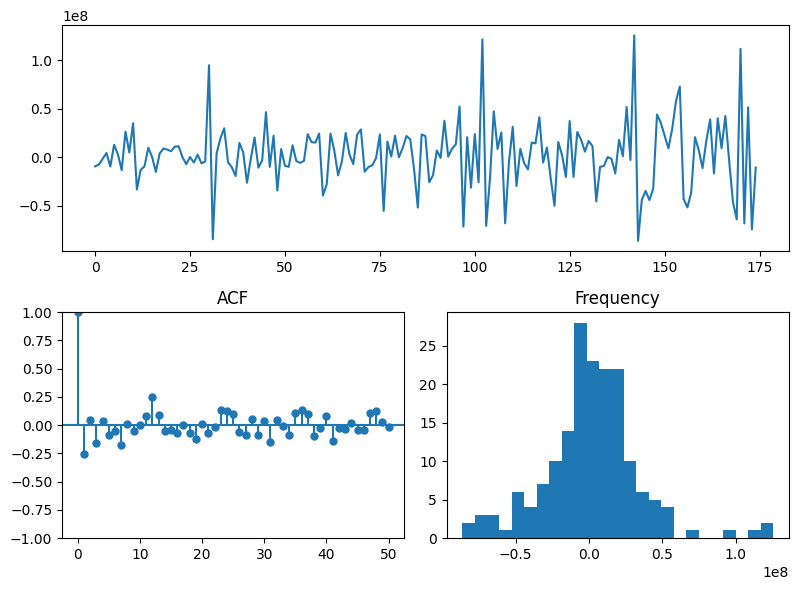

In [21]:
df_icms_dif = df_treino['ICMS'] - df_treino['ICMS'].shift(1)
tsdisplay(df_icms_dif.dropna())

In [13]:
teste_adf_icms_dif = adfuller(df_icms_dif.dropna(), regression = 'c')
print('Estatística ADF - Constante: %f' %teste_adf_icms_dif[0])
print('p-valor: %f' %teste_adf_icms_dif[1])
print('=-----------------------------------=')
teste_kpss_icms_dif = kpss(df_icms_dif.dropna())
print('Estatística KPSS: %f' %teste_kpss_icms_dif[0])
print('p-valor: %f' %teste_kpss_icms_dif[1])
print('=-----------------------------------=')
teste_pp_icms_dif = PhillipsPerron(df_icms_dif.dropna())
print(teste_pp_icms_dif.summary().as_text())

Estatística ADF - Constante: -4.815793
p-valor: 0.000051
=-----------------------------------=
Estatística KPSS: 0.048095
p-valor: 0.100000
=-----------------------------------=
     Phillips-Perron Test (Z-tau)    
Test Statistic                -23.989
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


No teste de Dickey Fuller Aumentado, a hipótese nula é de que a série contém raiz unitária, e a alternativa é de que a série é estacionária.
 - se eu rejeito a nula (abaixo de 5%), a série é estacionária;
 - se eu falho em rejeitar (acima de 5%), a série tem raiz unitária.

No teste de KPSS, a hipótese nula é que a série é estacionária, e a alternativa de que a série tem raiz unitária.
 - se eu rejeito a nula, a série tem raiz unitária;
 - se eu falho em rejeitar a nula, a série é estacionária.

O teste de Phillips-Perron funciona similarmente ao teste de Dickey-Fuller, contudo sua análise difere ao não incluir as defasagens ao rodar a regressão. Nele:
 - se eu rejeito a nula, a série é estacionária;
 - se eu falho em rejeitar, a série tem raiz unitária.

Os valores apresentados por ambos os testes apontam que a série não é estacionária, uma vez que:

1. O teste de Dickey Fuller Aumentado apresenta p-valor acima de 1%, 5% e 10%, falhando em rejeitar a hipótese nula de que a série contém raiz unitária, determinando que a série não é estacionária;
2. O teste de KPSS apresenta p-valor abaixo de 1%, rejeitando a hipótese nula de que a série é estacionária;
3. O teste de Phillips-Perron apresentou p-valor acima de 5%, falhando em rejeitar a hipótese nula de que a série contém raiz unitária.

Desta maneira, como todos os testes apontam para a presença de raiz unitária na série, resta aplicar a diferença nas séries para a estacionarização da mesma, e consequente aplicação do método de Box-Jenkins.

A seguir, é realizada a análise dos gráficos de autocorrelação e autocorrelação parcial, objetivando a determinação dos parâmetros p (AR) e q (MA).

Para tal, o procedimento consiste em analisar os pontos que se apresentam fora do intervalo de confiança em ambos os gráficos, indicando quantos parâmetros auto-regressivos (AR) e/ou de médias móveis (MA) se fazem significativos e são possíveis de se observar no modelo.

Vale ressaltar que o parâmetro de integração d já é determinado no momento em que se analisa a estacionariedade da série, neste caso sendo 1 vide a presença de raiz unitária.

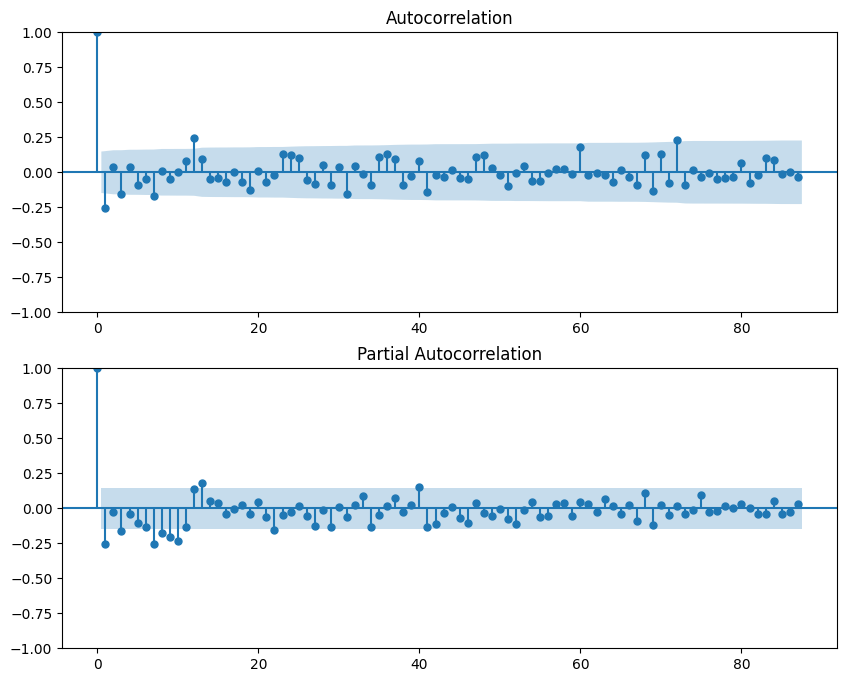

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (10,8))
plot_acf(df_icms_dif.dropna(), lags = 87, ax = ax1)
plot_pacf(df_icms_dif.dropna(), lags = 87, ax = ax2)
plt.show();

A análise dos gráficos de autocorrelação e autocorrelação parcial indicará os parâmetros _q_ e _p_, respectivamente.  
É visível que há uma observação fora do intervalo de confiança no gráfico de autocorrelação, indicando que o parâmetro _q_ pode ser 0 ou 1, e o mesmo ocorre no gráfico de autocorrelação parcial, _p_ podendo ser 0 ou 1.

Após a análise do ACF, podemos observar indícios de sazonalidade com periodicidade de 12 meses, uma vez que nos pontos 12 e 72 temos pontos fora do intervalo de confiança. Em tempo, o modelo SARIMA também acrescenta a influência da sazonalidade no modelo. Para encontrar os parâmetros sazonais, é necessário realizar a diferenciação sazonal da série observada e realizar a mesma análise feita para os parâmetros não-sazonais, com a diferença de que serão observados os pontos anuais.

Assim, será realizada a diferenciação sazonal (df(t) - df(t+12)) para plotagem dos gráficos de autocorrelação (para análise do parâmetro _Q_) e autocorrelação parcial (para análise do parâmetro _P_) da série dessasonalizada, com o intuito de observar pontos sazonais significativos mesmo após a diferenciação.

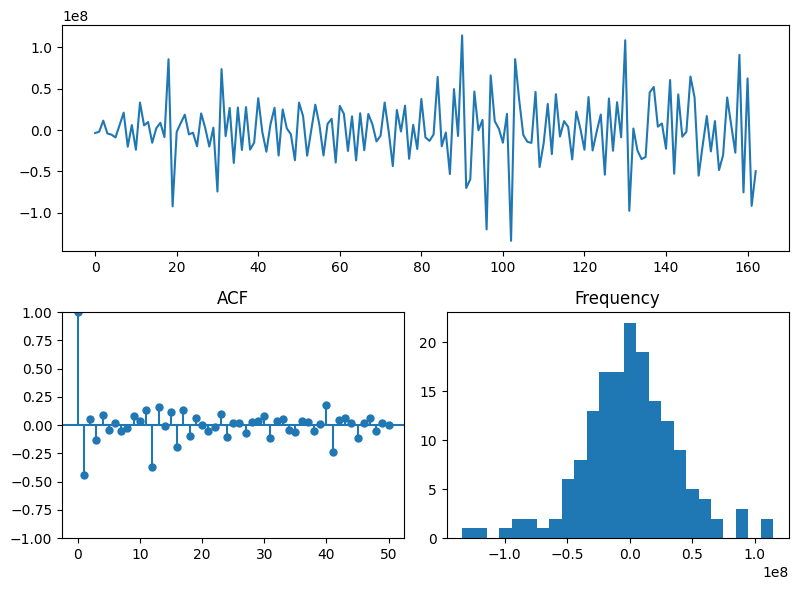

In [22]:
df_icms_dif_ns = df_icms_dif - df_icms_dif.shift(12)
df_icms_dif_ns = df_icms_dif_ns.dropna()
tsdisplay(df_icms_dif_ns)

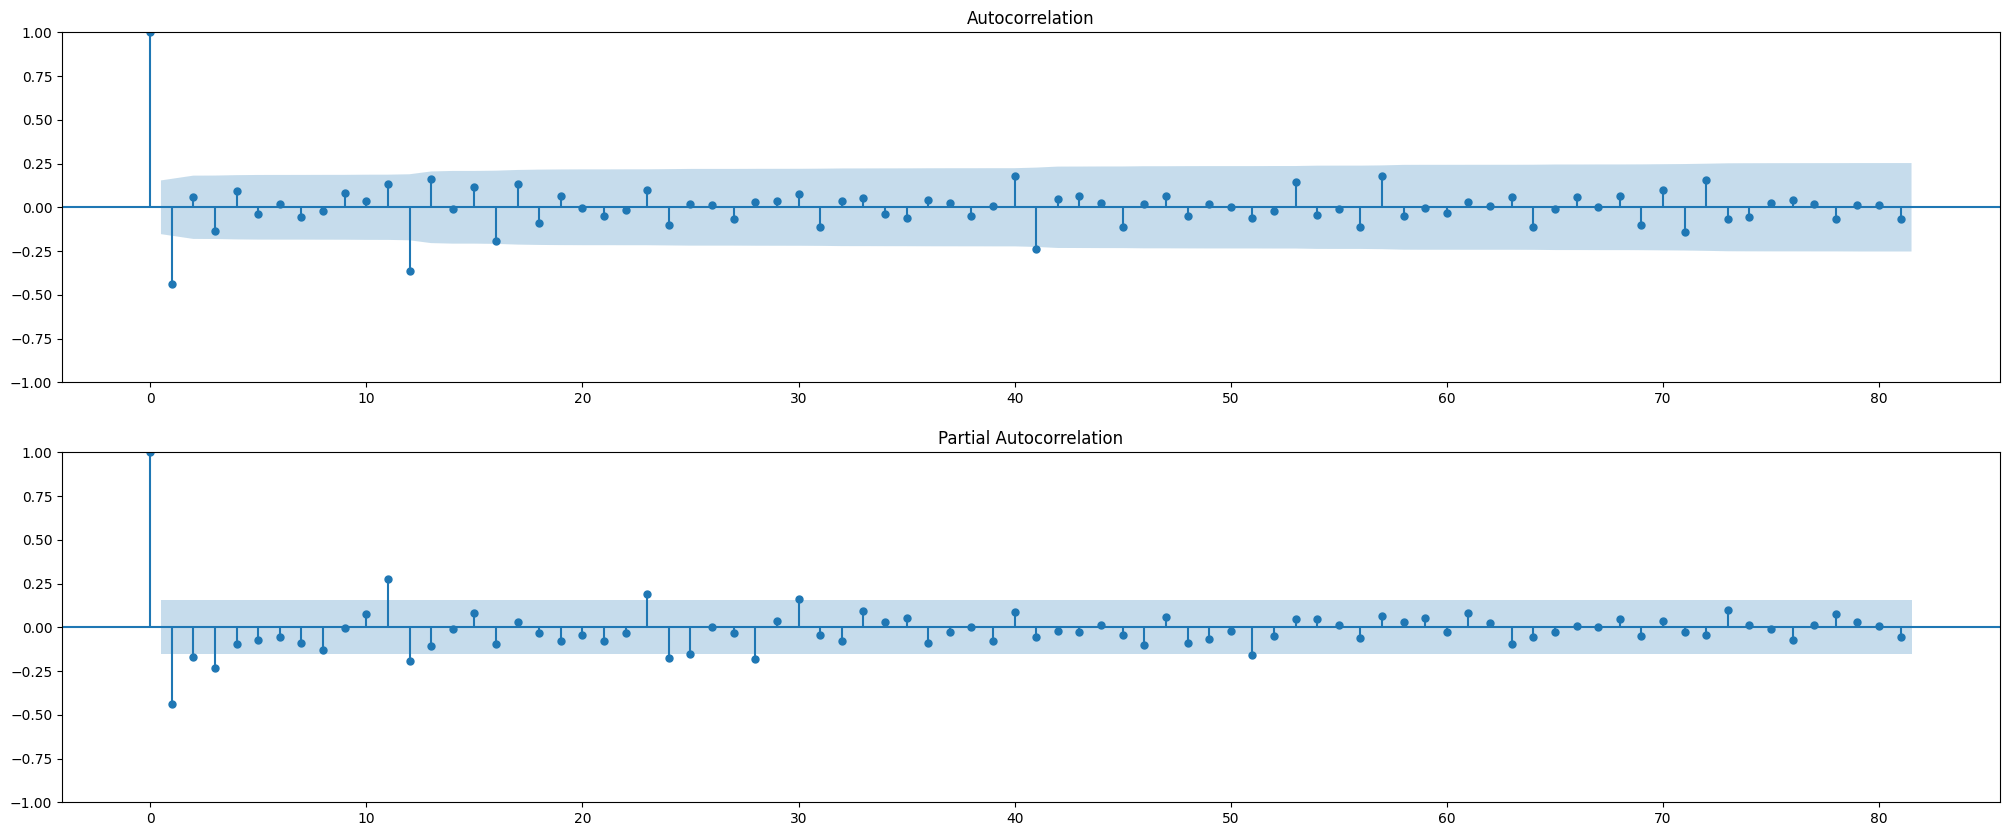

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (25,10))
plot_acf(df_icms_dif_ns, lags = 81, ax = ax1)
plot_pacf(df_icms_dif_ns, lags = 81, ax = ax2)
plt.show();

Analisando o gráfico de autocorrelação da série diferenciada sazonalmente, observa-se um parâmetro significativo no período 12, apontando que _Q_ pode ser 0 ou 1. Já a análise do gráfico de autocorrelação parcial aponta observações significantes nos pontos 12 e 24, sendo _P_  0, 1 ou 2.

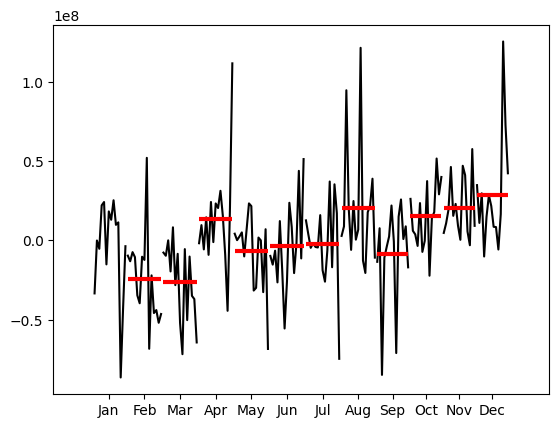

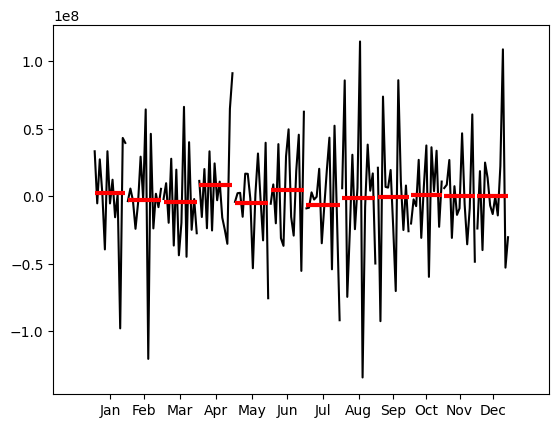

In [20]:
month_plot(df_icms_dif)
month_plot(df_icms_dif_ns);

Para realizar a análise dos coeficientes, vamos primeiramente explicitar os passos dados até aqui:
1. Primeiramente, tem-se a série do ICMS;
2. Logo então, a análise gráfica da série sugere que o modelo não é estacionário em nível. São aplicados os testes de Dickey-Fuller Aumentado, KPSS e Phillips-Perron, e todos atestam a hipótese de não-estacionaridade. Desta forma, realiza-se a diferença da série com o intuito de estacionarizá-la;
3. E então, observando os pontos significativos periodicizados em 12 observações, atesta-se que a série possui indícios de sazonalidade anual. Para tratar do caso, faz-se a diferenciação sazonal em doze meses.

Até então, tem-se o seguinte para os parâmetros (p,d,q)(P,D,Q)s do modelo:
1. Como a série precisou ser diferenciada tanto em nível quanto em sua sazonalidade (12 meses), tem-se que os coeficientes _d_ e _D_ serão 1;
2. Conforme o gráfico de autocorrelação e o de autocorrelação parcial, tem-se que os valores de _p_ podem adotar os valores de 0 ou 1, enquanto os valores de _q_ podem adotar os valores de 0 ou 1;
3. Para os coeficientes sazonais, a PACF da série diferenciada sazonalmente apresenta valores significativos nas defasagens 12 e 24, indicando um _P_ podendo adotar os valores 0, 1 e 2, enquanto os valores da ACF apresentam significância apenas na defasagem 12, representando um _Q_ entre 0 ou 1.

Assim, iremos criar as combinaçoes possíveis dentro de uma array e testar cada um dos modelos para determinar qual destes possui menor AIC.

In [23]:
modelos = [
    SARIMAX(df_treino['ICMS'], order = (0,1,0), seasonal_order = (0,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,0), seasonal_order = (0,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,1), seasonal_order = (0,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,1), seasonal_order = (0,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,0), seasonal_order = (1,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,0), seasonal_order = (1,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,1), seasonal_order = (1,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,1), seasonal_order = (1,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,0), seasonal_order = (2,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,0), seasonal_order = (2,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,1), seasonal_order = (2,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,1), seasonal_order = (2,1,0,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,0), seasonal_order = (0,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,0), seasonal_order = (0,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,1), seasonal_order = (0,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,1), seasonal_order = (0,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,0), seasonal_order = (1,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,0), seasonal_order = (1,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,1), seasonal_order = (1,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,1), seasonal_order = (1,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,0), seasonal_order = (2,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,0), seasonal_order = (2,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,1), seasonal_order = (2,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,1), seasonal_order = (2,1,1,12))
]

In [258]:
resultados = [modelo.fit(disp = False) for modelo in modelos]

for i, resultado in enumerate(resultados):
  print(f'Modelo {i + 1} - AIC: {resultado.aic}, BIC: {resultado.bic}')
#  print(resultado.summary())
  print(' ')

Modelo 1 - AIC: 6143.39415077622, BIC: 6152.956308193742
 
Modelo 2 - AIC: 6144.332935733135, BIC: 6157.082478956498
 
Modelo 3 - AIC: 6147.837559102322, BIC: 6160.587102325685
 
Modelo 4 - AIC: 6146.215110944937, BIC: 6162.15203997414
 


Inicialmente, visualizam-se os modelos com menor AIC para logo após isolá-los com o intuito de realizar a análise dos resultados de cada um dos modelos.

In [259]:
modelos = [
    SARIMAX(df_treino['ICMS'], order = (0,1,1), seasonal_order = (0,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,1), seasonal_order = (0,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,1), seasonal_order = (1,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,1), seasonal_order = (1,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (0,1,1), seasonal_order = (2,1,1,12)),
    SARIMAX(df_treino['ICMS'], order = (1,1,1), seasonal_order = (2,1,1,12))
    ]

In [260]:
resultados = [modelo.fit(disp = False) for modelo in modelos]

for i, resultado in enumerate(resultados):
  print(f'Modelo {i + 1} - AIC: {resultado.aic}, BIC: {resultado.bic}')
  print(resultado.summary())
  print(' ')

Modelo 1 - AIC: 6073.200492554875, BIC: 6082.481743157296
                                     SARIMAX Results                                      
Dep. Variable:                               ICMS   No. Observations:                  176
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3033.600
Date:                            Fri, 26 Jul 2024   AIC                           6073.200
Time:                                    17:33:50   BIC                           6082.482
Sample:                                01-01-2008   HQIC                          6076.969
                                     - 08-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5245      0.086     -6.068      0.000  

Ao plotar o sumário dos resultados de cada modelo, temos as informações essenciais para determinar a adequação dos resultados com a significância esperada para estes. Para além do menor AIC, buscam-se modelos que tenham coeficientes significativos e testes estatísticos que venham a assegurar a confiabilidade dos resultados destes.

A significância dos coeficientes pode ser visualizada na probabilidade de _z_ ser menor que o p-valor determinado.

Já os testes que também estão disponíveis no sumário são os de Ljung-Box (que testa a autocorrelação dos erros), Jarque-Bera (que testa a normalidade dos erros) e de Heterocedasticidade (que testa a variação constante dos resíduos). Por último, tem-se a visualização do nível de skew (assimetria) e kurtosis (curtose) dos resíduos.    

O modelo que apresentou o menor coeficiente de AIC, assim como as melhores significâncias para os estimadores.

Contudo, deve-se atentar para os seguintes fatos:
1. O teste de Jarque-Bera abaixo de 5% rejeita a hipótese nula de normalidade dos erros;
2. O teste de Ljung-Box acima de 5% falha em rejeitar a hipótese nula de autocorrelação dos erros;
3. O teste de Heterocedasticidade abaixo de 5% rejeita a hipótese nula de homocedasticidade.

## Previsão ICMS

In [261]:
order = (0,1,1)
seasonal_order = (0,1,1,12)

In [262]:
sarima_icms = pm.ARIMA(order = order, seasonal_order = seasonal_order, suppress_warnings=True)
sarima_icms.fit(df_treino['ICMS'])

ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

In [263]:
prev_icms = sarima_icms.predict(n_periods= 16, return_conf_int=False)
prev_icms = pd.DataFrame(prev_icms, columns=['Previsão Modelo 1'])
prev_icms

Previsão Modelo 1
2022-09-01       4.673349e+08
2022-10-01       4.956640e+08
2022-11-01       5.174248e+08
2022-12-01       5.663836e+08
2023-01-01       5.488806e+08
2023-02-01       5.090255e+08
2023-03-01       4.681865e+08
2023-04-01       5.012768e+08
2023-05-01       4.769867e+08
2023-06-01       4.930216e+08
2023-07-01       4.798556e+08
2023-08-01       4.934175e+08
2023-09-01       5.003808e+08
2023-10-01       5.287066e+08
2023-11-01       5.504643e+08
2023-12-01       5.994199e+08

<Figure size 1500x500 with 0 Axes>

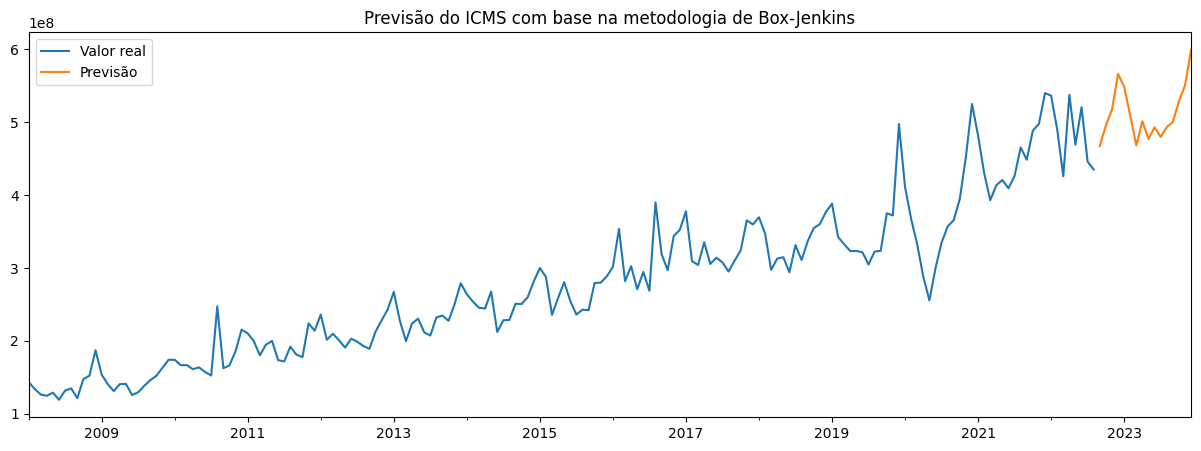

In [214]:
plt.figure(figsize = (15,5))
pd.concat([df_treino['ICMS'],prev_icms], axis=1).plot(figsize=(15,5))
plt.title('Previsão do ICMS com base na metodologia de Box-Jenkins')
plt.legend(['Valor real','Previsão'])

### Intervalos de previsão e confiança

In [264]:
# ICMS

# Utilizando z-score de distribuição normal
n = len(prev_icms)
prev_icms['error'] = df_real['ICMS'] - prev_icms['Previsão Modelo 1']
s = prev_icms['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

prev_icms['conf_interval'] = t * s / np.sqrt(n)
prev_icms['pred_interval'] = t * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
prev_icms['conf_lower'] = prev_icms['Previsão Modelo 1'] - prev_icms['conf_interval']
prev_icms['conf_upper'] = prev_icms['Previsão Modelo 1'] + prev_icms['conf_interval']
prev_icms['pred_lower'] = prev_icms['Previsão Modelo 1'] - prev_icms['pred_interval']
prev_icms['pred_upper'] = prev_icms['Previsão Modelo 1'] + prev_icms['pred_interval']
prev_icms

Previsão Modelo 1         error  conf_interval  pred_interval  \
2022-09-01       4.673349e+08 -1.567586e+07   3.364391e+07   1.387174e+08   
2022-10-01       4.956640e+08 -4.219143e+06   3.364391e+07   1.387174e+08   
2022-11-01       5.174248e+08 -1.666739e+07   3.364391e+07   1.387174e+08   
2022-12-01       5.663836e+08 -4.867763e+07   3.364391e+07   1.387174e+08   
2023-01-01       5.488806e+08 -2.979401e+07   3.364391e+07   1.387174e+08   
2023-02-01       5.090255e+08 -1.757461e+07   3.364391e+07   1.387174e+08   
2023-03-01       4.681865e+08  2.385181e+07   3.364391e+07   1.387174e+08   
2023-04-01       5.012768e+08  2.277357e+07   3.364391e+07   1.387174e+08   
2023-05-01       4.769867e+08  5.999945e+07   3.364391e+07   1.387174e+08   
2023-06-01       4.930216e+08  6.099345e+07   3.364391e+07   1.387174e+08   
2023-07-01       4.798556e+08  7.253196e+07   3.364391e+07   1.387174e+08   
2023-08-01       4.934175e+08  6.443819e+07   3.364391e+07   1.387174e+08   
2023-09-01       5.003808e+08  6.386797e+07   3.364391e+07   1.387174e+08   
2023-10-01       5.287066e+08  5.782219e+07   3.364391e+07   1.387174e+08   
2023-11-01       5.504643e+08  7.306399e+07   3.364391e+07   1.387174e+08   
2023-12-01       5.994199e+08  2.150925e+08   3.364391e+07   1.387174e+08   

              conf_lower    conf_upper    pred_lower    pred_upper  
2022-09-01  4.336910e+08  5.009788e+08  3.286175e+08  6.060523e+08  
2022-10-01  4.620201e+08  5.293079e+08  3.569466e+08  6.343814e+08  
2022-11-01  4.837809e+08  5.510687e+08  3.787074e+08  6.561422e+08  
2022-12-01  5.327397e+08  6.000275e+08  4.276662e+08  7.051010e+08  
2023-01-01  5.152367e+08  5.825245e+08  4.101632e+08  6.875980e+08  
2023-02-01  4.753816e+08  5.426694e+08  3.703081e+08  6.477429e+08  
2023-03-01  4.345426e+08  5.018304e+08  3.294691e+08  6.069039e+08  
2023-04-01  4.676329e+08  5.349207e+08  3.625594e+08  6.399942e+08  
2023-05-01  4.433428e+08  5.106307e+08  3.382693e+08  6.157041e+08  
2023-06-01  4.593777e+08  5.266655e+08  3.543042e+08  6.317390e+08  
2023-07-01  4.462117e+08  5.134995e+08  3.411382e+08  6.185730e+08  
2023-08-01  4.597736e+08  5.270614e+08  3.547001e+08  6.321349e+08  
2023-09-01  4.667368e+08  5.340247e+08  3.616634e+08  6.390982e+08  
2023-10-01  4.950627e+08  5.623506e+08  3.899892e+08  6.674241e+08  
2023-11-01  5.168204e+08  5.841083e+08  4.117469e+08  6.891817e+08  
2023-12-01  5.657760e+08  6.330639e+08  4.607025e+08  7.381374e+08

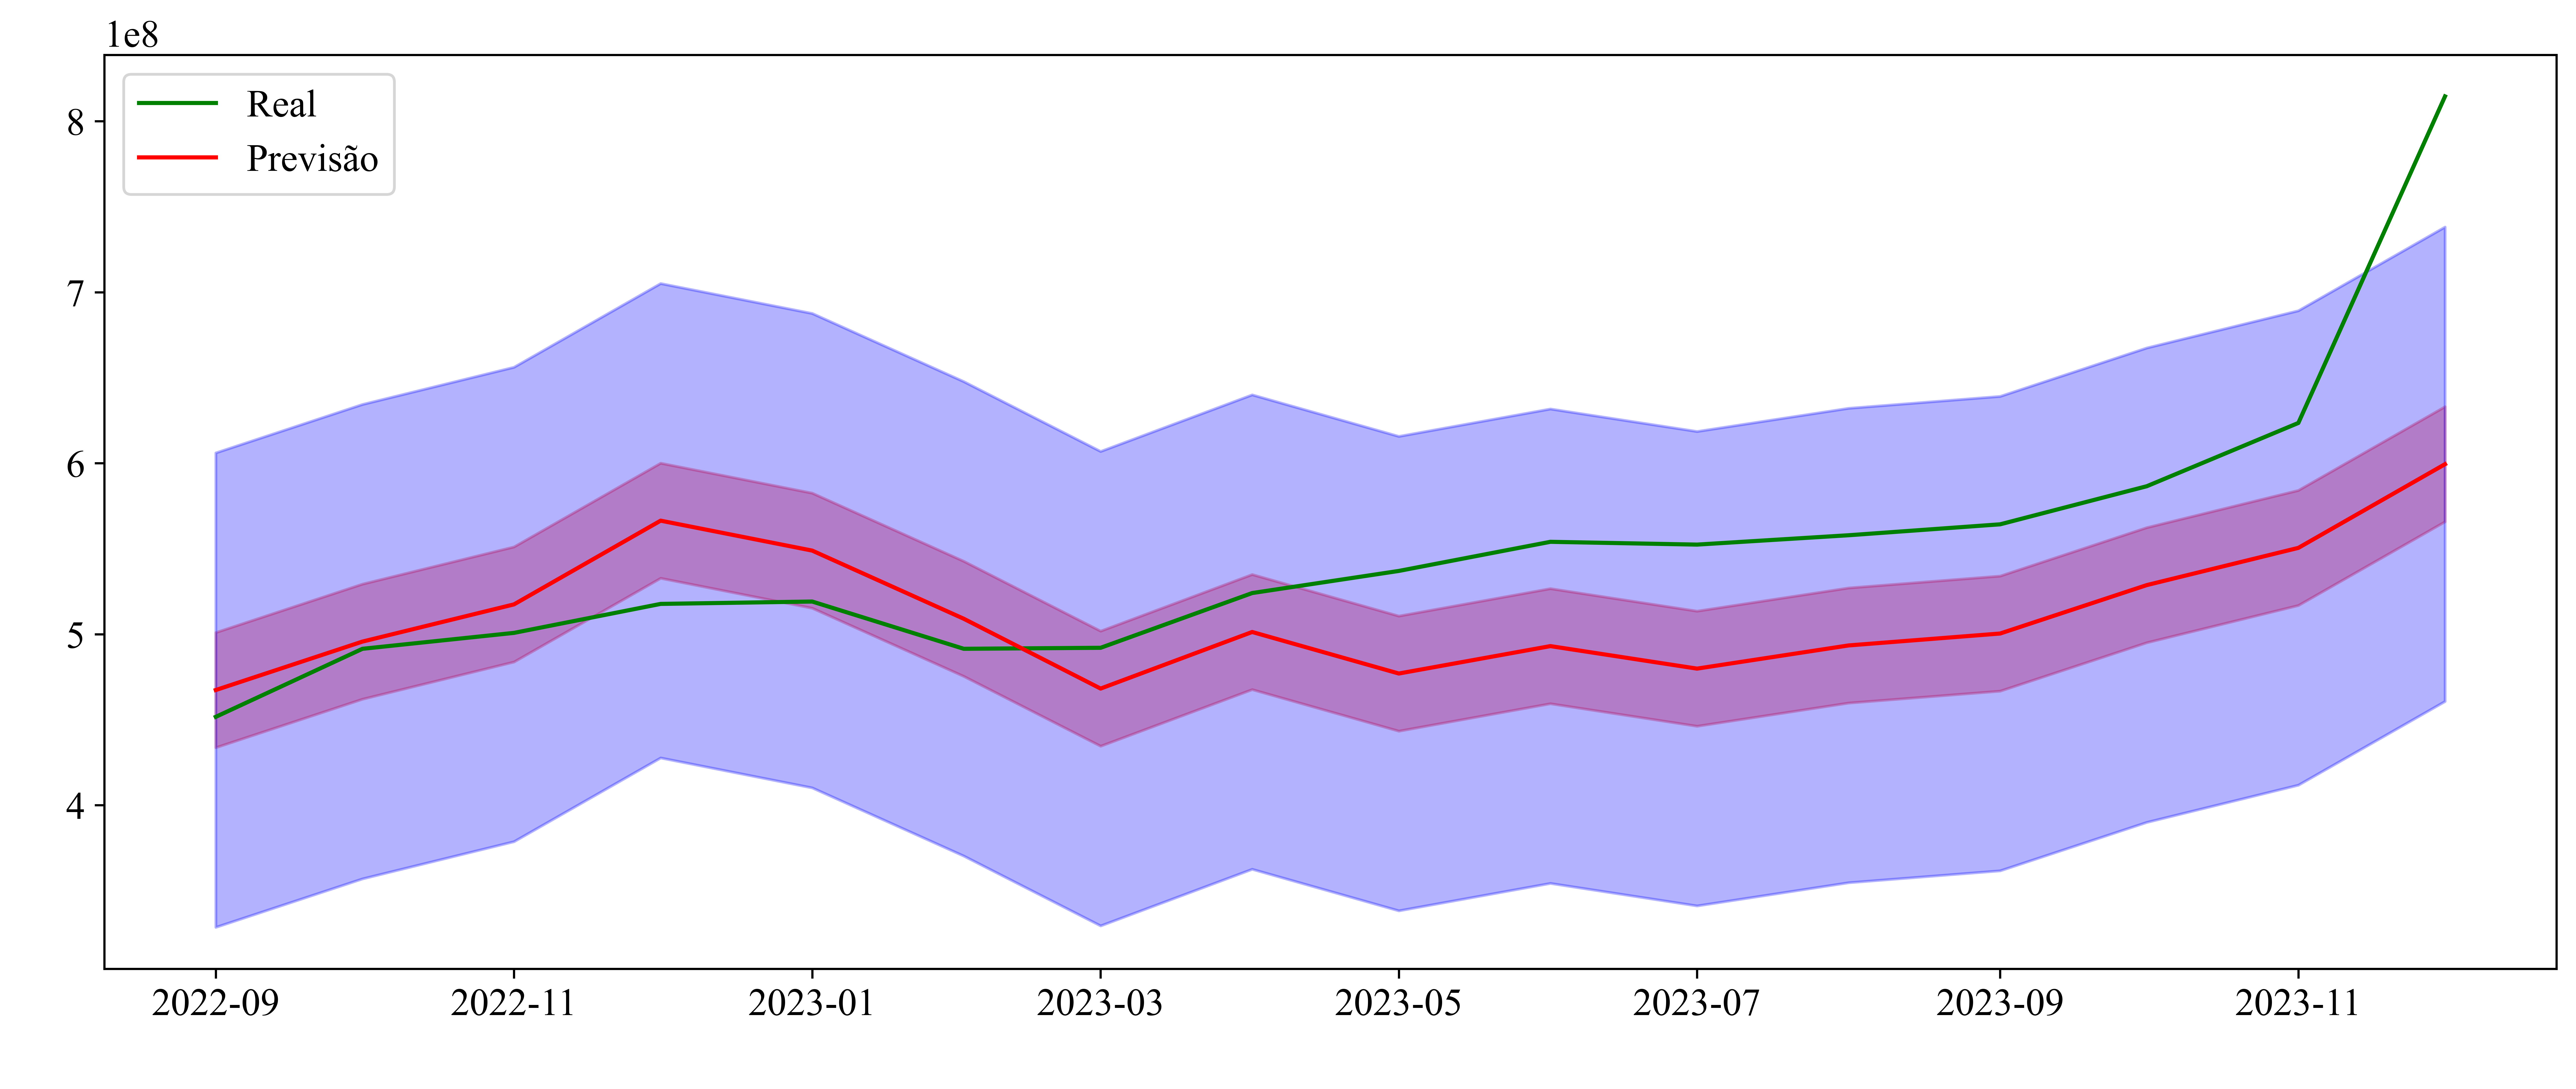

In [265]:
plt.figure(figsize = (16,6))
#plt.title('Previsão do ICMS com base na metodologia de Box-Jenkins', size = 18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.legend(['Valor Real', 'Previsão'])
sns.lineplot(x = df_real.loc[df_real.index >= '2022-09-01'].index,
             y = df_real.loc[df_real.index >= '2022-09-01'].ICMS,
             color = 'green',
             label = 'Real')
sns.lineplot(x = prev_icms.index,
             y = prev_icms['Previsão Modelo 1'],
             color = 'red',
             label = 'Previsão')
plt.fill_between(prev_icms.index, prev_icms['conf_lower'], prev_icms['conf_upper'], alpha = 0.3, color = 'Red')
plt.fill_between(prev_icms.index, prev_icms['pred_lower'], prev_icms['pred_upper'], alpha = 0.3, color = 'Blue')

### Intervalo de confiança sugerido por Makridakis _apud_ Box-Jenkins (1987)

$$\hat{X}_t(h) \pm Z_{\alpha/2} \left[ 1 + \sum_{j=1}^{h-1} \psi_j^2 \right]^{1/2} S_e$$


In [197]:
model = sarima_icms.arima_res_
psi_weights = model.polynomial_ma
psi_weights

array([ 1.        , -0.52450922])

In [187]:
psi_weights = sarima_icms.arima_res_.polynomial_ma
psi_weights

array([ 1.        , -0.52450922])

In [208]:
# Cálculo dos pesos psi_j
model = sarima_icms.arima_res_
psi_weights = model.polynomial_ma

# Parâmetros do modelo ajustado
params = sarima_icms.arima_res_.params
sigma2 = params[3]
sigma2
n = len(df_treino['ICMS'])

# Cálculo do valor crítico para 95% de confiança
t_alpha_2 = stats.t.ppf(0.975, df=n-1)

# Função para calcular os intervalos de confiança
def calculate_conf_interval(prediction, psi_weights, S_e, t_alpha_2, h):
    psi_sum_sq = np.sum(psi_weights[:h]**2)
    conf_interval = t_alpha_2 * np.sqrt(1 + psi_sum_sq) * S_e
    lower_bound = prediction - conf_interval
    upper_bound = prediction + conf_interval
    return lower_bound, upper_bound

# Erro padrão da previsão
S_e = np.sqrt(sigma2)

# Calculando os intervalos de confiança para cada previsão
lower_bounds, upper_bounds = [], []
for i in range(1, 16+1):
    lb, ub = calculate_conf_interval(predictions[i-1], psi_weights, S_e, t_alpha_2, i)
    lower_bounds.append(lb)
    upper_bounds.append(ub)

# Criando as datas correspondentes
dates = pd.date_range(start='2022-09-01', periods=len(predictions), freq='MS')

# Criando o DataFrame
df_forecast = pd.DataFrame({
    'Date': dates,
    'Forecast': predictions,
    'Lower Bound': lower_bounds,
    'Upper Bound': upper_bounds
})

# Definindo a coluna 'Date' como índice
df_forecast.set_index('Date', inplace=True)


df_forecast

Forecast   Lower Bound   Upper Bound
Date                                                
2022-09-01  4.673349e+08  3.728712e+08  5.617987e+08
2022-10-01  4.956640e+08  3.949125e+08  5.964154e+08
2022-11-01  5.174248e+08  4.166733e+08  6.181763e+08
2022-12-01  5.663836e+08  4.656321e+08  6.671351e+08
2023-01-01  5.488806e+08  4.481291e+08  6.496321e+08
2023-02-01  5.090255e+08  4.082740e+08  6.097770e+08
2023-03-01  4.681865e+08  3.674350e+08  5.689380e+08
2023-04-01  5.012768e+08  4.005253e+08  6.020282e+08
2023-05-01  4.769867e+08  3.762353e+08  5.777382e+08
2023-06-01  4.930216e+08  3.922701e+08  5.937731e+08
2023-07-01  4.798556e+08  3.791041e+08  5.806071e+08
2023-08-01  4.934175e+08  3.926660e+08  5.941690e+08
2023-09-01  5.003808e+08  3.996293e+08  6.011322e+08
2023-10-01  5.287066e+08  4.279552e+08  6.294581e+08
2023-11-01  5.504643e+08  4.497129e+08  6.512158e+08
2023-12-01  5.994199e+08  4.986685e+08  7.001714e+08

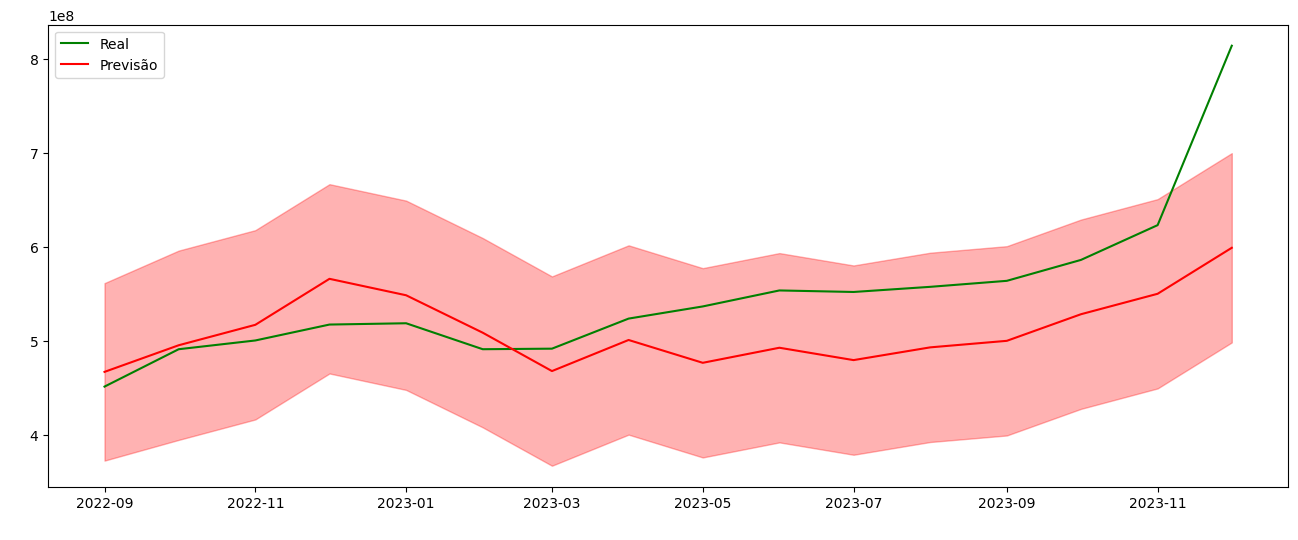

In [207]:
plt.figure(figsize = (16,6))
#plt.title('Previsão do ICMS com base na metodologia de Box-Jenkins', size = 18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.legend(['Valor Real', 'Previsão'])
sns.lineplot(x = df_real.loc[df_real.index >= '2022-09-01'].index,
             y = df_real.loc[df_real.index >= '2022-09-01'].ICMS,
             color = 'green',
             label = 'Real')
sns.lineplot(x = df_forecast.index,
             y = df_forecast['Forecast'],
             color = 'red',
             label = 'Previsão')
plt.fill_between(df_forecast.index, df_forecast['Lower Bound'], df_forecast['Upper Bound'], alpha = 0.3, color = 'Red')
#plt.fill_between(prev_icms.index, prev_icms['pred_lower'], prev_icms['pred_upper'], alpha = 0.3, color = 'Blue')



---



In [54]:
print(sarima_icms.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3033.598
Date:                            Fri, 26 Jul 2024   AIC                           6075.195
Time:                                    13:40:13   BIC                           6087.570
Sample:                                01-01-2008   HQIC                          6080.220
                                     - 08-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3160.2316   4.85e+05     -0.007      0.995   -9.54e+05    9.48e+05
ma.L1         -0.5245      0.086   

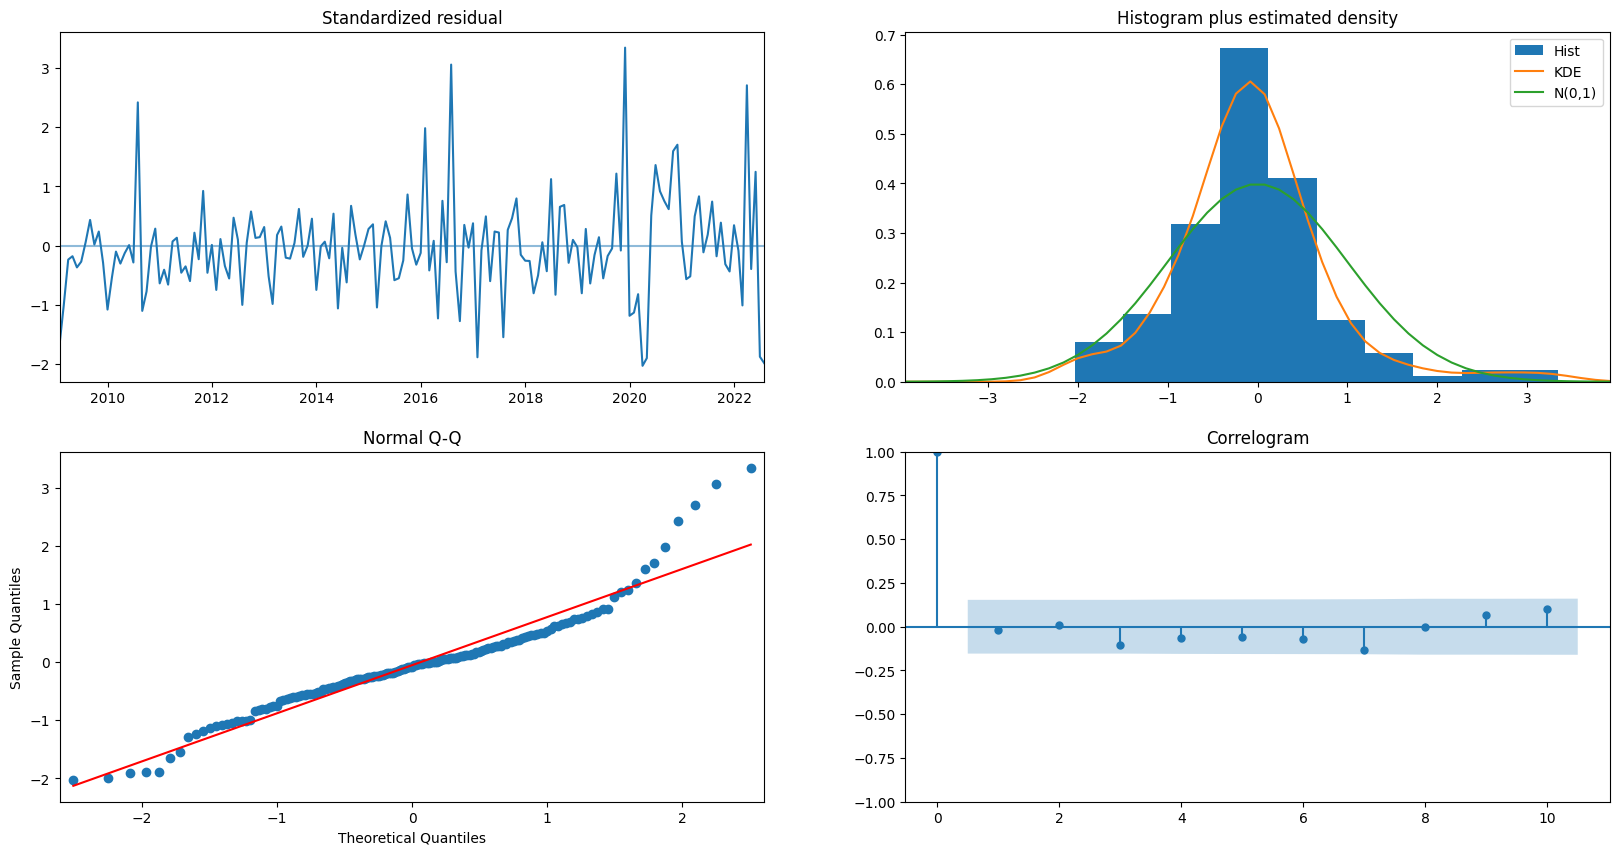

In [55]:
sarima_icms.plot_diagnostics(figsize = (20,10));

In [57]:
teste_mape = pd.DataFrame(df_real['ICMS'].loc['2022-09-01':'2023-12-31'])
print('MAPE:', round(MAPE(df_real['ICMS'], prev_icms['Previsão Modelo 1'])*100,2),"%")
print('MSE:', round(MSE(df_real['ICMS'], prev_icms['Previsão Modelo 1']),2))
print("RMSE do modelo: %.3f" % np.sqrt(MSE(df_real['ICMS'], prev_icms['Previsão Modelo 1'])))

MAPE: 8.86 %
MSE: 5059618812824228.0
RMSE do modelo: 71130997.553


## IPVA

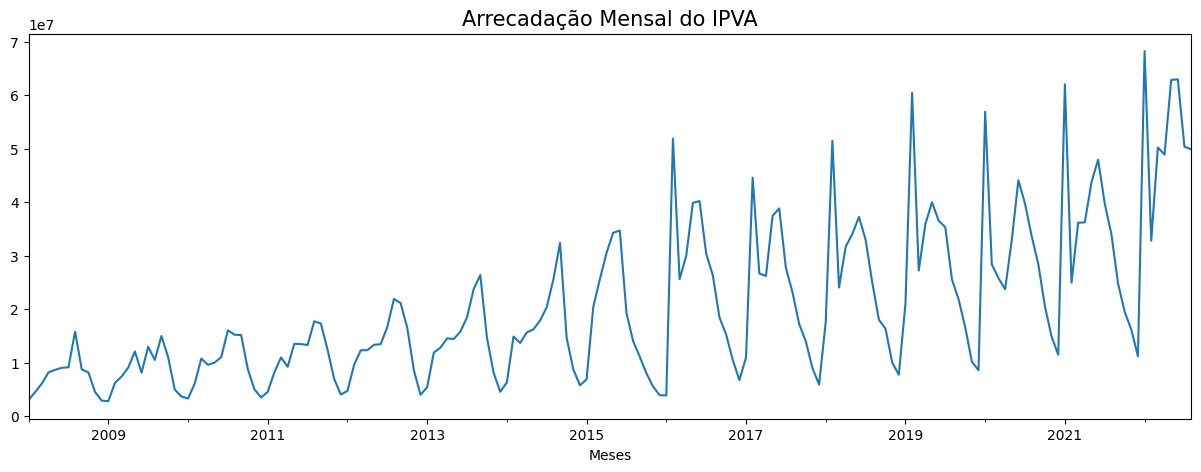

In [62]:
df_treino['IPVA'].plot(figsize=(15,5))
plt.xlabel('Meses')
plt.ylabel('')
plt.title('Arrecadação Mensal do IPVA', size = 15)
plt.show()

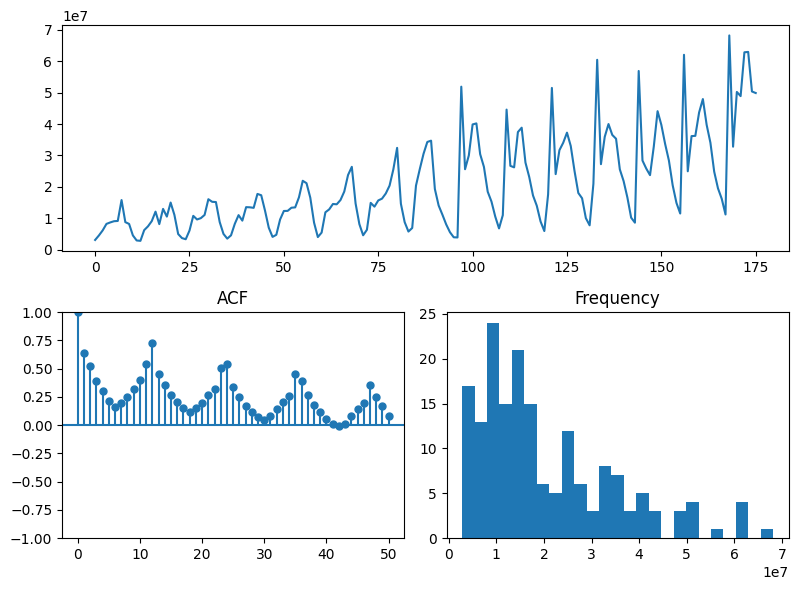

In [61]:
tsdisplay(df_treino['IPVA'])

In [63]:
teste_adf_ipva = adfuller(df_treino['IPVA'])
print('Estatística ADF - Constante: %f' %teste_adf_ipva[0])
print('p-valor: %f' %teste_adf_ipva[1])
print('=-----------------------------------=')
teste_kpss_ipva = kpss(df_treino['IPVA'])
print('Estatística KPSS: %f' %teste_kpss_ipva[0])
print('p-valor: %f' %teste_kpss_ipva[1])
print('=-----------------------------------=')
teste_pp_ipva = PhillipsPerron(df_treino['IPVA'])
print(teste_pp_ipva.summary().as_text())

Estatística ADF - Constante: 1.260613
p-valor: 0.996379
=-----------------------------------=
Estatística KPSS: 1.980816
p-valor: 0.010000
=-----------------------------------=
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -6.849
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


As estatísticas apontam para uma série não-estacionária.

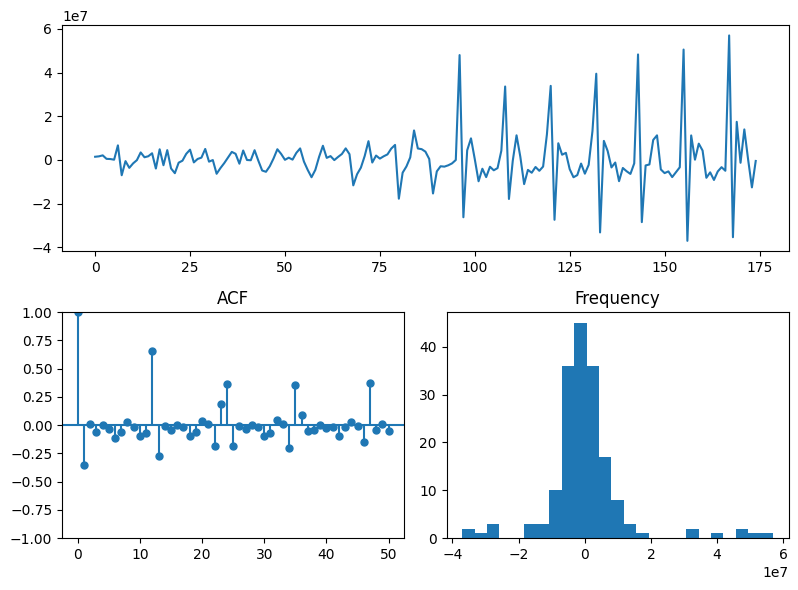

In [64]:
df_ipva_dif = df_treino['IPVA'] - df_treino['IPVA'].shift(1)
tsdisplay(df_ipva_dif.dropna())

In [65]:
teste_adf_ipva_dif = adfuller(df_ipva_dif.dropna())
print('Estatística ADF - Constante: %f' %teste_adf_ipva_dif[0])
print('p-valor: %f' %teste_adf_ipva_dif[1])
print('=-----------------------------------=')
teste_kpss_ipva_dif = kpss(df_ipva_dif.dropna())
print('Estatística KPSS: %f' %teste_kpss_ipva_dif[0])
print('p-valor: %f' %teste_kpss_ipva_dif[1])
print('=-----------------------------------=')
teste_pp_ipva_dif = PhillipsPerron(df_ipva_dif.dropna())
print(teste_pp_ipva_dif.summary().as_text())

Estatística ADF - Constante: -5.453504
p-valor: 0.000003
=-----------------------------------=
Estatística KPSS: 0.061943
p-valor: 0.100000
=-----------------------------------=
     Phillips-Perron Test (Z-tau)    
Test Statistic                -32.343
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Após a primeira diferença, a série apresenta estacionaridade, indicando o parâmetro _d_ como sendo 1.

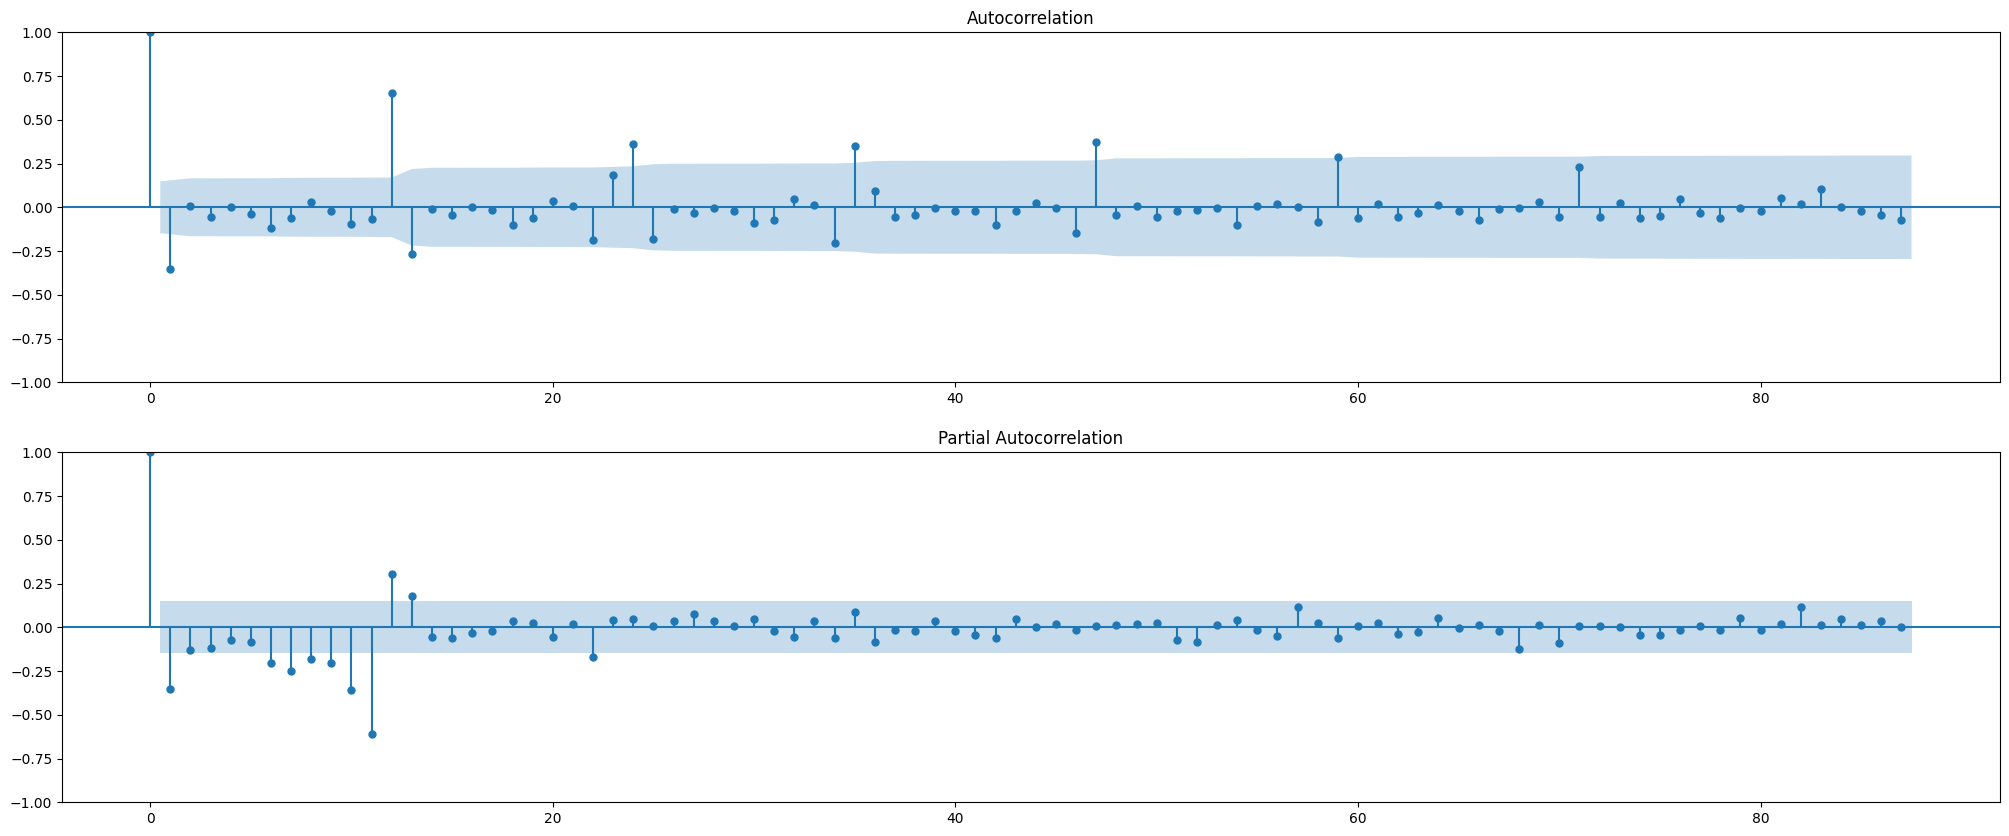

In [66]:
df_ipva_dif = df_ipva_dif.dropna()
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (25,10))
plot_acf(df_ipva_dif, lags = 87, ax = ax1)
plot_pacf(df_ipva_dif, lags = 87, ax = ax2)
plt.show();

A análise gráfica do gráfico de autocorrelação indica que o parâmetro _q_ pode adotar os valores de 0 ou 1.

A análise gráfica do gráfico de autocorrelação parcial indica que o parâmetro _p_ pode adotar os valores de 0 ou 1.

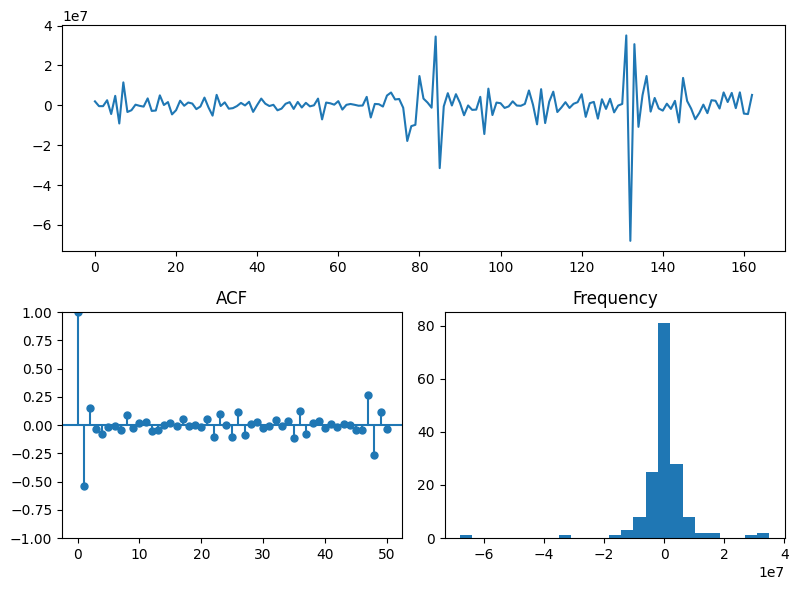

In [67]:
df_ipva_dif_ns = df_ipva_dif - df_ipva_dif.shift(12)
tsdisplay(df_ipva_dif_ns.dropna())

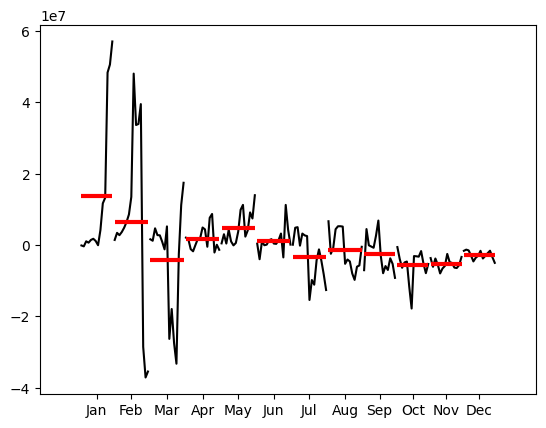

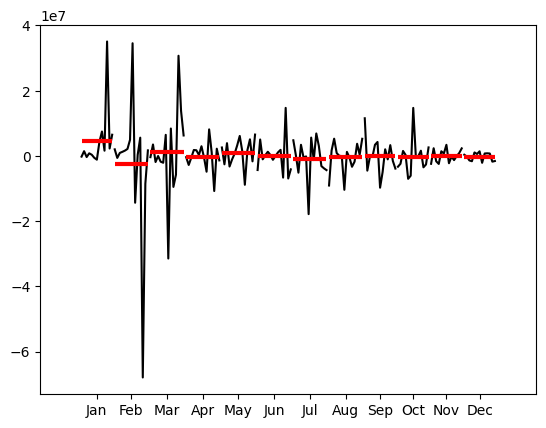

In [68]:
month_plot(df_ipva_dif)
month_plot(df_ipva_dif_ns.dropna());

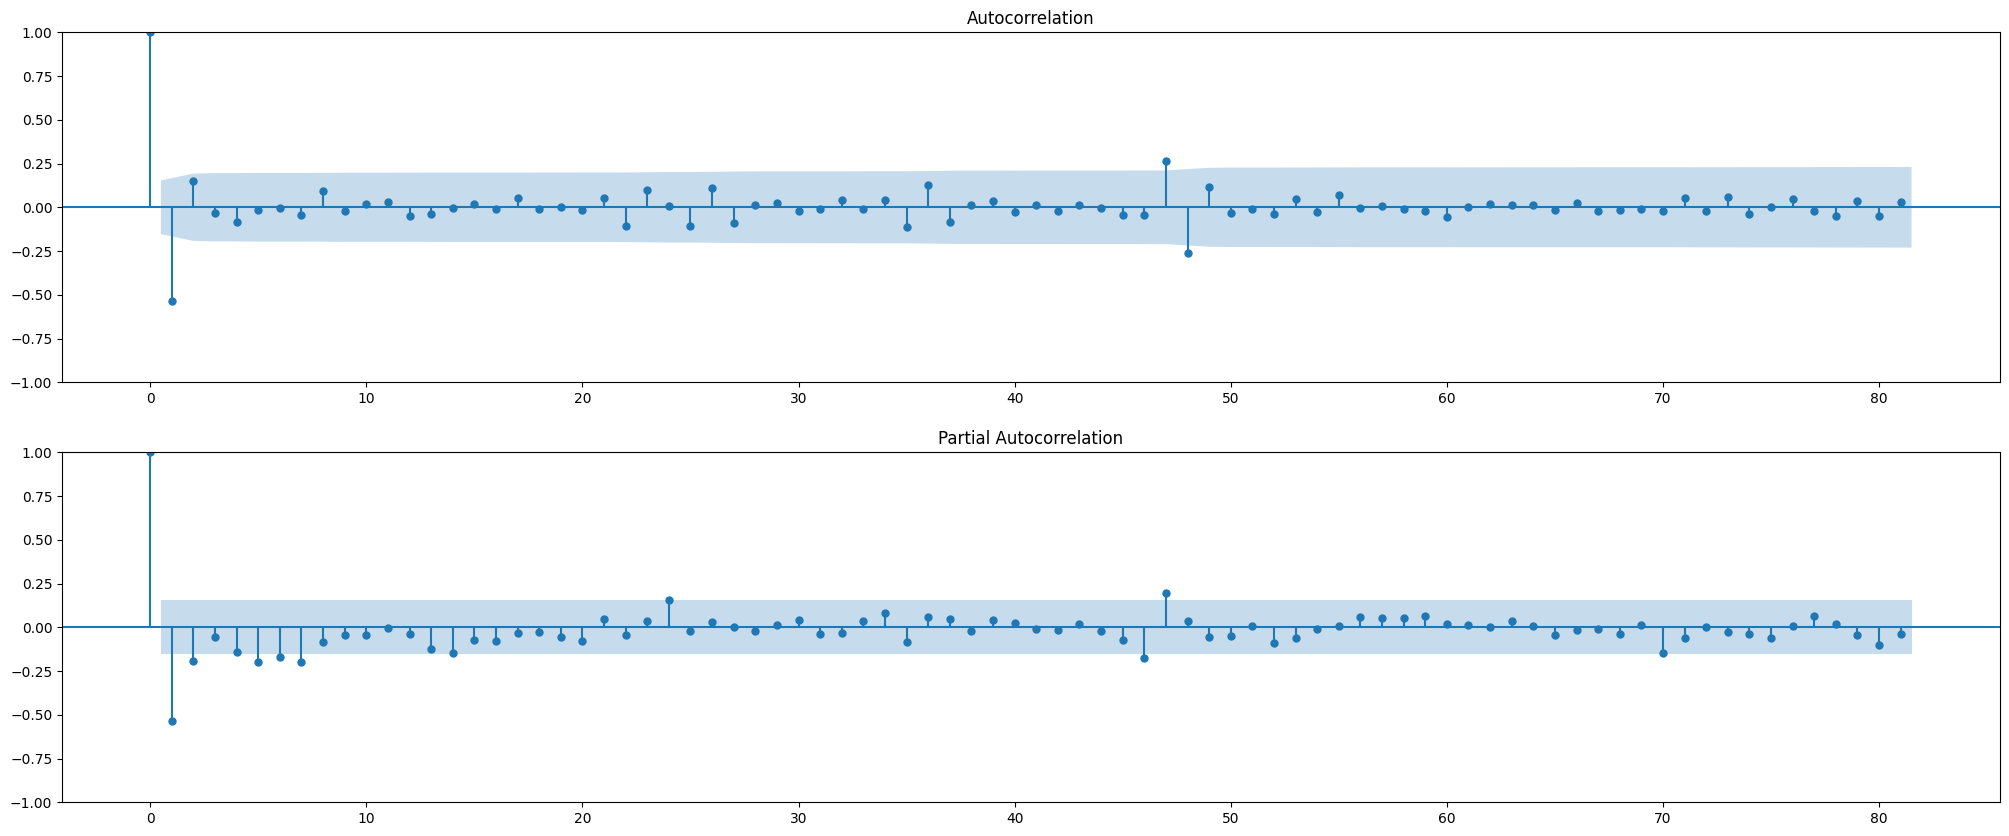

In [69]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (25,10))
plot_acf(df_ipva_dif_ns.dropna(), lags = 81, ax = ax1)
plot_pacf(df_ipva_dif_ns.dropna(), lags = 81, ax = ax2)
plt.show();

A série apresenta sazonalidade, havendo a necessidade de realizar a diferenciação sazonal. Contudo, após a realização desta, não existem autocorrelações significativas nos lags sazonais da série. I.E. não tem nenhum ponto múltiplo de 12 que sobressaia o intervalo de confiança nos gráficos. Assim, o modelo terá os parâmetros sazonais _P_ e _Q_ sendo 0, enquanto o _D_ será 1.



Q pode ser 1 ou 2
P é 0


In [267]:
modelos = [
    SARIMAX(df_ipva, order = (0,1,0), seasonal_order = (0,1,0,12)),
    SARIMAX(df_ipva, order = (1,1,0), seasonal_order = (0,1,0,12)),

    SARIMAX(df_ipva, order = (0,1,1), seasonal_order = (0,1,0,12)),
    SARIMAX(df_ipva, order = (1,1,1), seasonal_order = (0,1,0,12)),

    SARIMAX(df_ipva, order = (0,1,0), seasonal_order = (0,1,1,12)),
    SARIMAX(df_ipva, order = (1,1,0), seasonal_order = (0,1,1,12)),

    SARIMAX(df_ipva, order = (0,1,1), seasonal_order = (0,1,1,12)),
    SARIMAX(df_ipva, order = (1,1,1), seasonal_order = (0,1,1,12)),

    SARIMAX(df_ipva, order = (0,1,0), seasonal_order = (0,1,2,12)),
    SARIMAX(df_ipva, order = (1,1,0), seasonal_order = (0,1,2,12)),

    SARIMAX(df_ipva, order = (0,1,1), seasonal_order = (0,1,2,12)),
    SARIMAX(df_ipva, order = (1,1,1), seasonal_order = (0,1,2,12))

]

In [71]:
resultados = [modelo.fit(disp = False) for modelo in modelos]

for i, resultado in enumerate(resultados):
  print(f'Modelo {i + 1} - AIC: {resultado.aic}, BIC: {resultado.bic}')
#  print(resultado.summary())
  print(' ')

Modelo 1 - AIC: 6224.834413444328, BIC: 6228.021799250168
 
Modelo 2 - AIC: 6169.534006231599, BIC: 6175.90877784328
 
Modelo 3 - AIC: 6145.645120802257, BIC: 6152.019892413939
 
Modelo 4 - AIC: 6143.39415077622, BIC: 6152.956308193742
 
Modelo 5 - AIC: 6228.958349671939, BIC: 6235.33312128362
 
Modelo 6 - AIC: 6169.811523943237, BIC: 6179.373681360759
 
Modelo 7 - AIC: 6145.89273350166, BIC: 6155.454890919182
 
Modelo 8 - AIC: 6144.332935733135, BIC: 6157.082478956498
 
Modelo 9 - AIC: 6244.453803656203, BIC: 6254.015961073725
 
Modelo 10 - AIC: 6171.407891456658, BIC: 6184.157434680021
 
Modelo 11 - AIC: 6147.837559102322, BIC: 6160.587102325685
 
Modelo 12 - AIC: 6146.215110944937, BIC: 6162.15203997414
 


Os modelos com menor AIC são os modelos 4 e 8.

In [120]:
modelos = [
    SARIMAX(df_ipva, order = (1,1,1), seasonal_order = (0,1,0,12)),
    SARIMAX(df_ipva, order = (1,1,1), seasonal_order = (0,1,1,12)),
    SARIMAX(df_ipva, order = (0,1,1), seasonal_order = (0,1,2,12)),
    SARIMAX(df_ipva, order = (1,1,1), seasonal_order = (0,1,2,12))
]

In [73]:
resultados = [modelo.fit(disp = False) for modelo in modelos]

for i, resultado in enumerate(resultados):
  print(f'Modelo {i + 1} - AIC: {resultado.aic}, BIC: {resultado.bic}')
  print(resultado.summary())
  print(' ')

Modelo 1 - AIC: 6143.39415077622, BIC: 6152.956308193742
                                      SARIMAX Results                                      
Dep. Variable:                                IPVA   No. Observations:                  192
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood               -3068.697
Date:                             Fri, 26 Jul 2024   AIC                           6143.394
Time:                                     13:54:39   BIC                           6152.956
Sample:                                 01-01-2008   HQIC                          6147.272
                                      - 12-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1672      0.047      3.548      

O modelo que apresentou o menor coeficiente de AIC, assim como as melhores significâncias para os estimadores, foi o (1,1,1)x(0,1,0,12).

Contudo, deve-se atentar para os seguintes fatos:
1. O teste de Jarque-Bera abaixo de 5% rejeita a hipótese nula de normalidade dos erros.
2. O teste de Ljung-Box acima de 5% falha em rejeitar a hipótese nula de autocorrelação dos erros.

## Previsão IPVA

In [128]:
sarima_ipva = pm.ARIMA(order = (1,1,1), seasonal_order = (0,1,0,12))
sarima_ipva.fit(df_treino['IPVA'])

ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 0, 12))

<Figure size 1500x500 with 0 Axes>

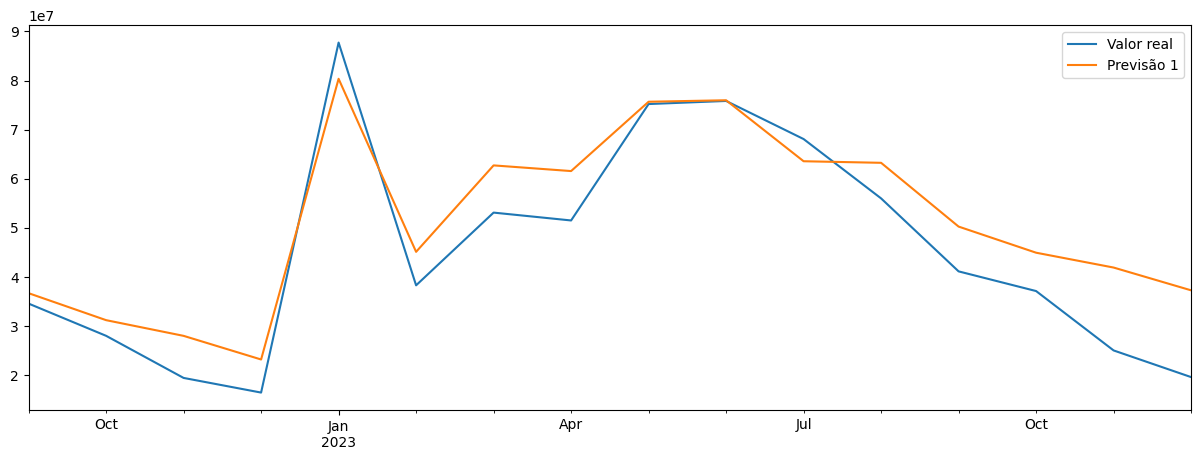

In [129]:
prev_ipva = sarima_ipva.predict(n_periods = 16)
plt.figure(figsize = (15,5))
pd.concat([df_real['IPVA'],prev_ipva], axis = 1).plot(figsize=(15,5))
plt.legend(['Valor real', 'Previsão 1'])

In [148]:
prev_ipva = pd.DataFrame(prev_ipva, index = df_real.index, columns = ['Previsão Modelo 1'])
prev_ipva

Previsão Modelo 1
Data                         
2022-09-01       3.670067e+07
2022-10-01       3.120794e+07
2022-11-01       2.801142e+07
2022-12-01       2.319816e+07
2023-01-01       8.035831e+07
2023-02-01       4.511965e+07
2023-03-01       6.272246e+07
2023-04-01       6.156699e+07
2023-05-01       7.568496e+07
2023-06-01       7.598562e+07
2023-07-01       6.356781e+07
2023-08-01       6.324827e+07
2023-09-01       5.026163e+07
2023-10-01       4.494312e+07
2023-11-01       4.192082e+07
2023-12-01       3.728179e+07

### Intervalos de previsão e confiança

In [149]:
# ICMS

# Utilizando z-score de distribuição normal
n = len(prev_ipva)
prev_ipva['error'] = df_real['IPVA'] - prev_ipva['Previsão Modelo 1']
s = prev_ipva['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

prev_ipva['conf_interval'] = t * s / np.sqrt(n)
prev_ipva['pred_interval'] = t * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
prev_ipva['conf_lower'] = prev_ipva['Previsão Modelo 1'] - prev_ipva['conf_interval']
prev_ipva['conf_upper'] = prev_ipva['Previsão Modelo 1'] + prev_ipva['conf_interval']
prev_ipva['pred_lower'] = prev_ipva['Previsão Modelo 1'] - prev_ipva['pred_interval']
prev_ipva['pred_upper'] = prev_ipva['Previsão Modelo 1'] + prev_ipva['pred_interval']
prev_ipva

Previsão Modelo 1         error  conf_interval  pred_interval  \
Data                                                                        
2022-09-01       3.670067e+07 -2.119582e+06   3.597259e+06   1.483188e+07   
2022-10-01       3.120794e+07 -3.188493e+06   3.597259e+06   1.483188e+07   
2022-11-01       2.801142e+07 -8.567255e+06   3.597259e+06   1.483188e+07   
2022-12-01       2.319816e+07 -6.737278e+06   3.597259e+06   1.483188e+07   
2023-01-01       8.035831e+07  7.373473e+06   3.597259e+06   1.483188e+07   
2023-02-01       4.511965e+07 -6.819872e+06   3.597259e+06   1.483188e+07   
2023-03-01       6.272246e+07 -9.613722e+06   3.597259e+06   1.483188e+07   
2023-04-01       6.156699e+07 -1.005809e+07   3.597259e+06   1.483188e+07   
2023-05-01       7.568496e+07 -4.704734e+05   3.597259e+06   1.483188e+07   
2023-06-01       7.598562e+07 -1.416291e+05   3.597259e+06   1.483188e+07   
2023-07-01       6.356781e+07  4.518482e+06   3.597259e+06   1.483188e+07   
2023-08-01       6.324827e+07 -7.246662e+06   3.597259e+06   1.483188e+07   
2023-09-01       5.026163e+07 -9.120640e+06   3.597259e+06   1.483188e+07   
2023-10-01       4.494312e+07 -7.809336e+06   3.597259e+06   1.483188e+07   
2023-11-01       4.192082e+07 -1.687798e+07   3.597259e+06   1.483188e+07   
2023-12-01       3.728179e+07 -1.766870e+07   3.597259e+06   1.483188e+07   

              conf_lower    conf_upper    pred_lower    pred_upper  
Data                                                                
2022-09-01  3.310341e+07  4.029793e+07  2.186879e+07  5.153255e+07  
2022-10-01  2.761068e+07  3.480520e+07  1.637606e+07  4.603982e+07  
2022-11-01  2.441416e+07  3.160868e+07  1.317954e+07  4.284329e+07  
2022-12-01  1.960090e+07  2.679541e+07  8.366278e+06  3.803003e+07  
2023-01-01  7.676105e+07  8.395557e+07  6.552643e+07  9.519019e+07  
2023-02-01  4.152240e+07  4.871691e+07  3.028778e+07  5.995153e+07  
2023-03-01  5.912520e+07  6.631972e+07  4.789058e+07  7.755434e+07  
2023-04-01  5.796974e+07  6.516425e+07  4.673512e+07  7.639887e+07  
2023-05-01  7.208770e+07  7.928222e+07  6.085308e+07  9.051684e+07  
2023-06-01  7.238836e+07  7.958288e+07  6.115374e+07  9.081750e+07  
2023-07-01  5.997055e+07  6.716507e+07  4.873593e+07  7.839969e+07  
2023-08-01  5.965101e+07  6.684552e+07  4.841639e+07  7.808014e+07  
2023-09-01  4.666437e+07  5.385889e+07  3.542975e+07  6.509351e+07  
2023-10-01  4.134586e+07  4.854038e+07  3.011124e+07  5.977500e+07  
2023-11-01  3.832356e+07  4.551808e+07  2.708895e+07  5.675270e+07  
2023-12-01  3.368453e+07  4.087905e+07  2.244991e+07  5.211366e+07

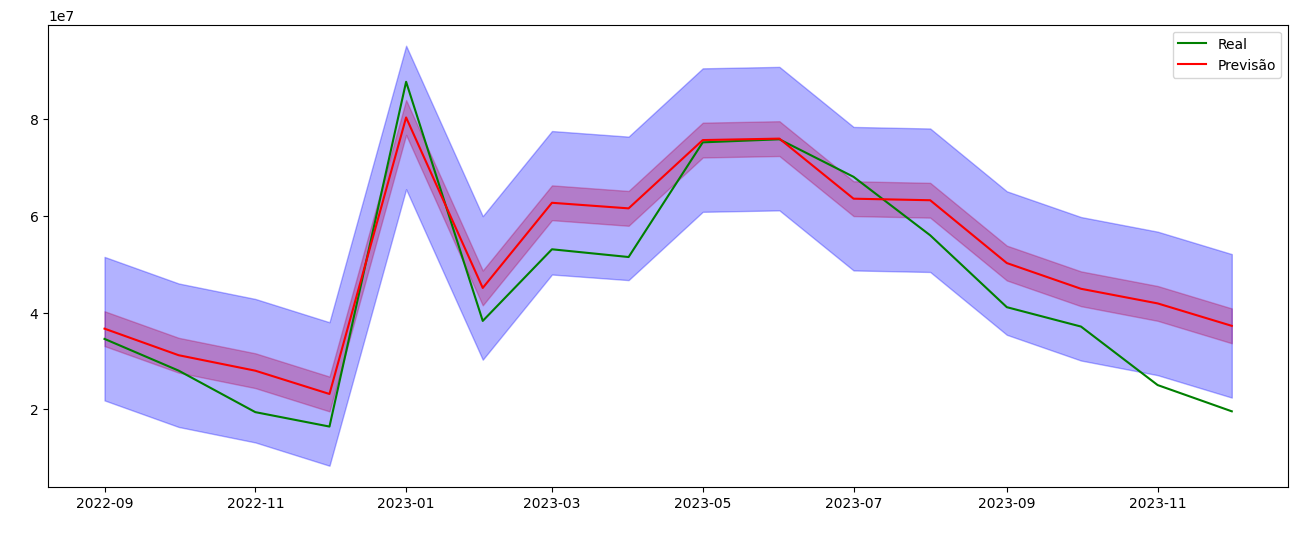

In [150]:
plt.figure(figsize = (16,6))
plt.ylabel(' ')
plt.xlabel(' ')
sns.lineplot(x = df_real['IPVA'].loc[df_real.index >= '2022-09-01'].index,
             y = df_real['IPVA'].loc[df_real.index >= '2022-09-01'],
             color = 'green',
             label = 'Real')
sns.lineplot(x=prev_ipva.index,
             y = prev_ipva['Previsão Modelo 1'],
             color = 'red',
             label = 'Previsão')
plt.fill_between(prev_ipva.index, prev_ipva['conf_lower'], prev_ipva['conf_upper'], alpha = 0.3, color = 'Red')
plt.fill_between(prev_ipva.index, prev_ipva['pred_lower'], prev_ipva['pred_upper'], alpha = 0.3, color = 'Blue')

In [136]:
print(sarima_ipva.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  176
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood               -2799.872
Date:                             Fri, 26 Jul 2024   AIC                           5607.745
Time:                                     14:26:54   BIC                           5620.120
Sample:                                 01-01-2008   HQIC                          5612.769
                                      - 08-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.59e+05   1.08e+05      1.474      0.141   -5.24e+04    3.71e+05
ar.L1          0.0872      

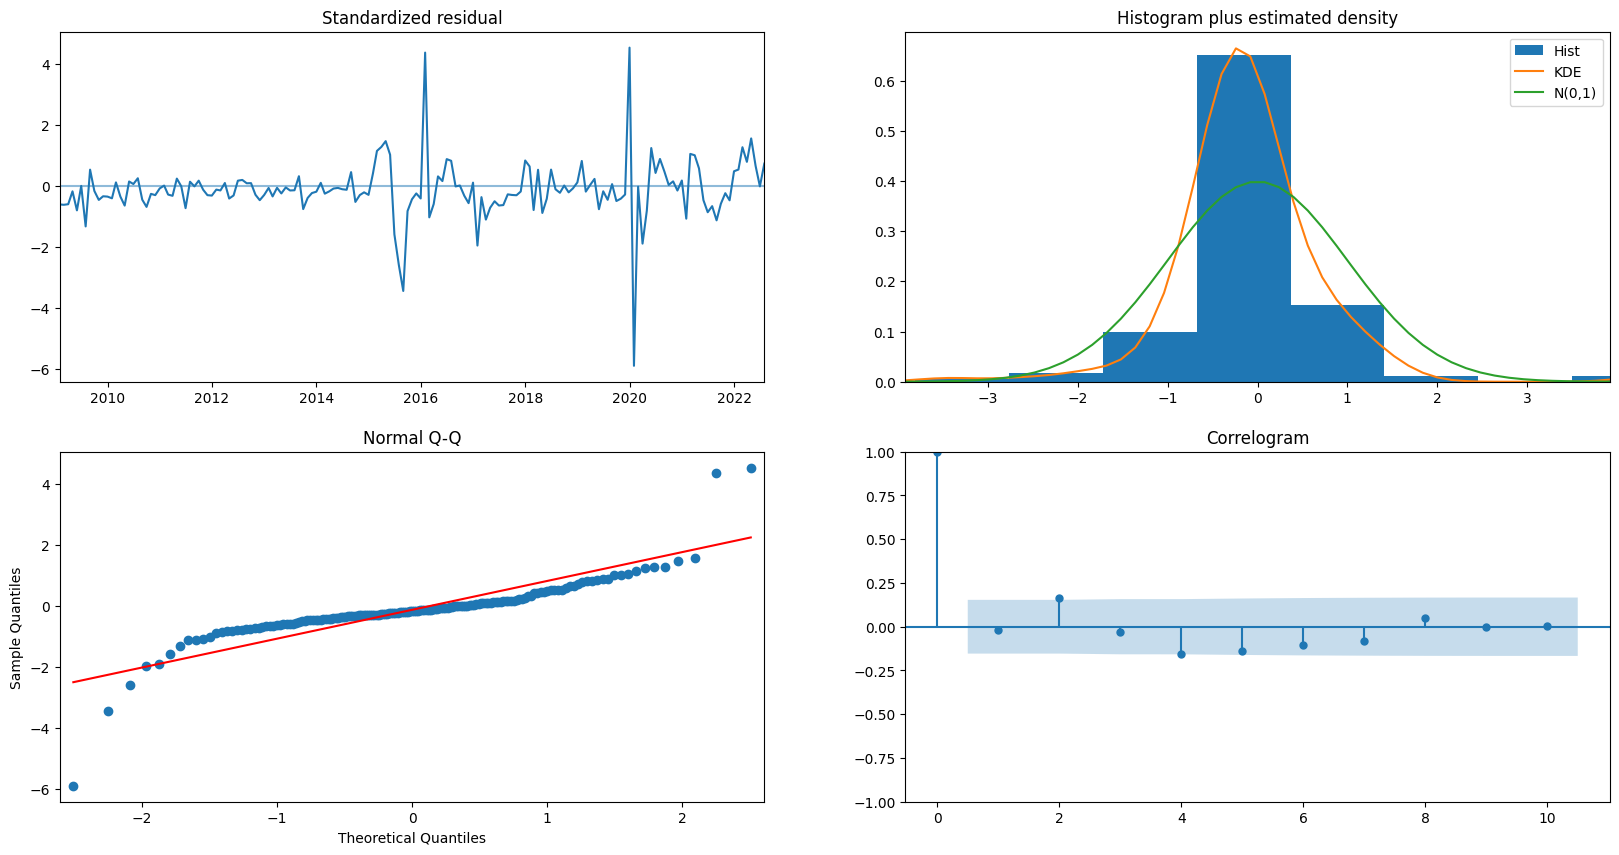

In [137]:
sarima_ipva.plot_diagnostics(figsize = (20,10));

In [ ]:
#prevplot_ipva_serie = pd.concat([prevplot_ipva['IPVA'], prevplot_ipva['Previsão Modelo 1']])

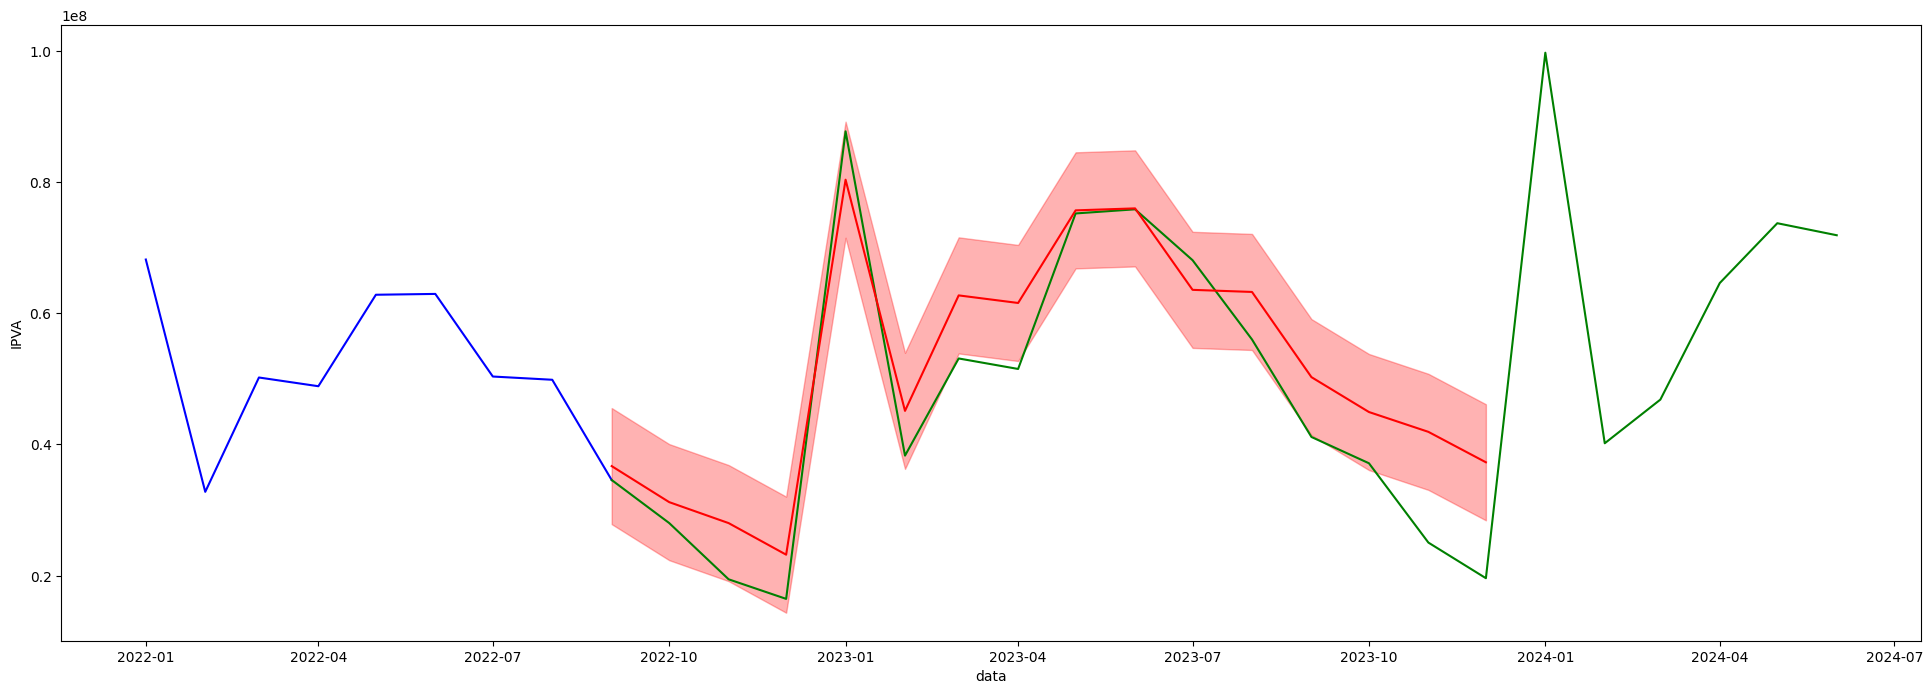

In [ ]:
plt.figure(figsize = (24, 8))

sns.lineplot(x = df_imp['IPVA'].loc['2022-01-01':'2022-09-02'].index,
             y = df_imp['IPVA'].loc['2022-01-01':'2022-09-02'],
             color = 'blue')
sns.lineplot(x = df_imp['IPVA'].loc['2022-09-01':'2024-06-02'].index,
             y = df_imp['IPVA'].loc['2022-09-01':'2024-06-02'],
             color = 'green')
sns.lineplot(x = prev_ipva['Previsão Modelo 1'].loc[prev_ipva['Previsão Modelo 1'].index >= '2022-09-01'].index,
             y = prev_ipva['Previsão Modelo 1'].loc[prev_ipva['Previsão Modelo 1'].index >= '2022-09-01'],
             color = 'red')
plt.fill_between(prev_ipva.index, prev_ipva['Intervalo Inferior'], prev_ipva['Intervalo Superior'], alpha=0.3, color='red')

In [ ]:
teste_mape = pd.DataFrame(df_imp['IPVA'].loc['2022-09-01':'2023-12-31'])
print('MAPE:', round(MAPE(teste_mape, prev_ipva['Previsão Modelo 1'].dropna())*100,2),"%")
print('MSE:', round(MSE(teste_mape, prev_ipva['Previsão Modelo 1'].dropna()),2))
print("RMSE do modelo: %.3f" % np.sqrt(MSE(teste_mape, prev_ipva['Previsão Modelo 1'].dropna())))

MAPE: 24.21 %
MSE: 77644298542355.25
RMSE do modelo: 8811600.226


# Aplicação do Auto_ARIMA

## ICMS

In [238]:
stepwise2 = auto_arima(df_treino['ICMS'],
                      start_p = 0,
                      start_q = 0,
                      d = 1,
                      max_p = 6,
                      max_q = 6,
                      max_d = 1,
                      start_P = 0,
                      start_Q = 0,
                      D = 1,
                      max_P = 2,
                      max_D = 2,
                      max_Q = 2,
                      max_order = 5,
                      m = 12,
                      seasonal = True,
                      trace = True,
                      error_action = 'ignore', supress_warnings = True,
                      stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6161.307, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6104.995, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=6073.200, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=6120.658, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=6075.153, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=6075.135, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=6094.501, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=6075.725, Time=2.59 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=6104.755, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=6074.308, Time=0.38 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=6074.474, Time=0.36 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=6080.680, Time=0.23 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=6076.548, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=6075.195, Time=0.27 sec

Best model:  ARIMA

In [239]:
stepwise3 = auto_arima(df_treino['ICMS'],
                      start_p = 0,
                      start_q = 0,
                      d = 1,
                      max_p = 6,
                      max_q = 6,
                      max_d = 1,
                      start_P = 0,
                      start_Q = 0,
                      D = 1,
                      max_P = 2,
                      max_D = 2,
                      max_Q = 2,
                      max_order = 5,
                      m = 12,
                      seasonal = True,
                      trace = True,
                      error_action = 'ignore', supress_warnings = True,
                      stepwise = False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6161.307, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=6104.755, Time=0.37 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=6118.117, Time=1.26 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=6135.020, Time=0.47 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=6105.944, Time=0.70 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=5.11 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=6117.828, Time=0.88 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=6101.849, Time=1.00 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=6110.645, Time=3.84 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=6120.658, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=6073.200, Time=0.40 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=6075.135, Time=1.26 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=6094.501, Time=0.35 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=6075.153, Time=1.01 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=6075.725, Time=6.75 sec


In [ ]:
stepwise2

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
print(stepwise2.aic())
print(stepwise2.bic())
print(' ')
print(stepwise3.aic())
print(stepwise3.bic())

6440.7942805406865
6450.25415532418
 
6439.695473648719
6455.461931621207


In [ ]:
treino = df_icms.loc['2008-01-01':'2023-06-01']
teste = df_imp['ICMS'].loc['2023-07-01':]

In [ ]:
stepwise2.fit(treino)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
previsao = stepwise2.predict(n_periods = 11)

In [ ]:
previsao

2023-07-01    5.319245e+08
2023-08-01    5.465732e+08
2023-09-01    5.478874e+08
2023-10-01    5.777281e+08
2023-11-01    5.960098e+08
2023-12-01    6.350369e+08
2024-01-01    6.250121e+08
2024-02-01    5.894999e+08
2024-03-01    5.604781e+08
2024-04-01    5.903734e+08
2024-05-01    5.773143e+08
Freq: MS, dtype: float64

In [ ]:
teste

data
2023-07-01    5.523875e+08
2023-08-01    5.578557e+08
2023-09-01    5.642487e+08
2023-10-01    5.865288e+08
2023-11-01    6.235283e+08
2023-12-01    8.145125e+08
2024-01-01    6.990115e+08
2024-02-01    6.385334e+08
2024-03-01    6.412978e+08
2024-04-01    6.901577e+08
2024-05-01    6.356771e+08
Name: ICMS, dtype: float64

In [ ]:
previsao = pd.DataFrame(previsao, index = teste.index, columns = ['prev modelo 1'])

In [ ]:
previsao

prev modelo 1
data                     
2023-07-01   5.319245e+08
2023-08-01   5.465732e+08
2023-09-01   5.478874e+08
2023-10-01   5.777281e+08
2023-11-01   5.960098e+08
2023-12-01   6.350369e+08
2024-01-01   6.250121e+08
2024-02-01   5.894999e+08
2024-03-01   5.604781e+08
2024-04-01   5.903734e+08
2024-05-01   5.773143e+08

<Figure size 1500x500 with 0 Axes>

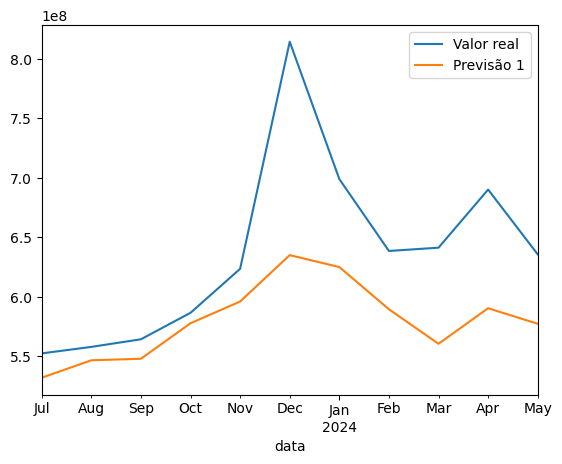

In [ ]:
plt.figure(figsize = (15,5))
pd.concat([teste,previsao], axis=1).plot()
plt.legend(['Valor real','Previsão 1'])

<Axes: xlabel='data'>

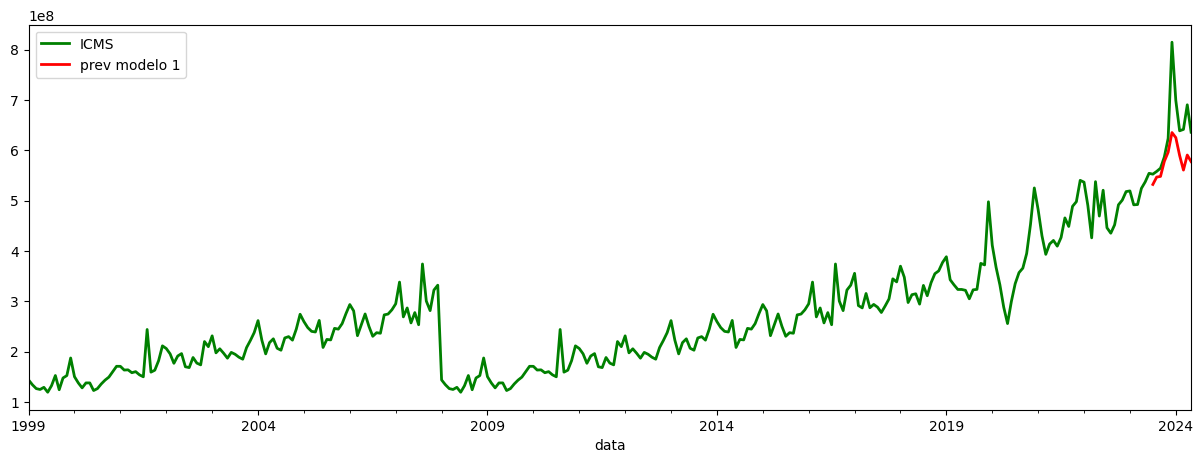

In [ ]:
pd.concat([df_imp['ICMS'],previsao],
          axis=1).plot(linewidth = 2,
                      figsize = (15,5),
                      color =['g','r'])

In [ ]:
stepwise2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  186
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3217.397
Date:                            Mon, 01 Jul 2024   AIC                           6440.794
Time:                                    11:16:47   BIC                           6450.254
Sample:                                01-01-2008   HQIC                          6444.632
                                     - 06-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4587      0.082     -5.592      0.000      -0.619      -0.298
ma.S.L12      -0.7525      0.086     -8.745      0.000      -0.921      -0.584
sigma2      1.121e+15   1.38e-17   8.12e+31      0.000    1.12e+15    1.12e+15
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                70.84
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               3.19   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.66e+47. Standard errors may be unstable.
"""

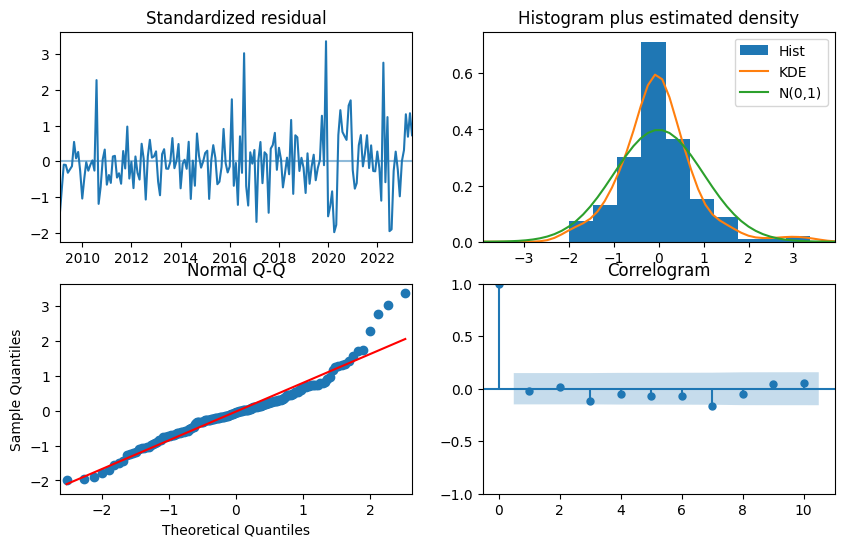

In [ ]:
stepwise2.plot_diagnostics(figsize = (10,6));

In [ ]:
teste_mape = pd.DataFrame(df_imp['ICMS'].loc['2023-07-01':'2024-05-01'])
print('MAPE:', round(MAPE(teste_mape, previsao['prev modelo 1'])*100,2),"%")
print('MSE:', round(MSE(teste_mape, previsao['prev modelo 1']),2))


MAPE: 8.28 %
MSE: 5603186933304543.0


In [ ]:

print("RMSE do modelo (treino vs treinado): %.3f" % np.sqrt(MSE(treino, predito)))
print("R² do modelo (treino vs treinado): %.3f" % r2_score(treino, predito))
print(''*254)
print("RMSE do modelo (teste vs previsões): %.3f" % np.sqrt(MSE(teste, previsao)))
print("R² do modelo (teste vs previsões): %.3f" % r2_score(teste, previsao))

RMSE do modelo (treino vs treinado): 29788289.784
R² do modelo (treino vs treinado): 0.932

RMSE do modelo (teste vs previsões): 74854438.301
R² do modelo (teste vs previsões): -0.033


### Previsão IPVA

In [ ]:
mod_wh_mm = ExponentialSmoothing(df_ipva, seasonal_periods=12, trend='mul', seasonal='mul').fit(optimized=1)
pred_wh_mm = pd.DataFrame(mod_wh_mm.forecast(18), columns = ['IPVA'])
predval_wh_mm = pd.concat([df_ipva, pred_wh_mm])
predval_wh_mm = pd.DataFrame(predval_wh_mm)
predval_wh_mm = predval_wh_mm.rename(columns={0: 'Previsto - HWmm'})

df3_ipva = pd.DataFrame(columns=['VALOR PREVISTO - MM'])
df3_ipva['VALOR PREVISTO - MM'] = pred_wh_mm

df3_ipva['Intervalo Inferior - MM'] = pred_wh_mm - 1.96 * pred_wh_mm.sem()
df3_ipva['Intervalo Superior - MM'] = pred_wh_mm + 1.96 * pred_wh_mm.sem()

path = 'IPVA Previsto.xlsx'

with pd.ExcelWriter(path) as writer:
    df3_ipva.to_excel(writer, sheet_name = 'Previstos')
    predval_wh_mm.to_excel(writer, sheet_name = 'Previsto_MM')

In [ ]:
predval_wh_mm

IPVA
2008-01-01  3.089290e+06
2008-02-01  4.518615e+06
2008-03-01  6.134471e+06
2008-04-01  8.201421e+06
2008-05-01  8.670808e+06
...                  ...
2025-08-01  7.844788e+07
2025-09-01  5.722500e+07
2025-10-01  5.084091e+07
2025-11-01  3.449060e+07
2025-12-01  2.720347e+07

[216 rows x 1 columns]

In [ ]:
n = len(mod_wh_mm.forecast(18))
s = predval_wh_mm.loc['2024-07-01':'2025-12-31'].std(ddof=1)

In [ ]:
s

IPVA    2.763651e+07
dtype: float64

In [ ]:
predval_wh_mm['Intervalo de Previsão'] = stats.t.ppf(0.975, n-1)* s['IPVA'] * np.sqrt(1 + 1/n)
predval_wh_mm['Intervalo Inferior de Previsão'] = predval_wh_mm['IPVA'] - predval_wh_mm['Intervalo de Previsão']
predval_wh_mm['Intervalo Superior de Previsão'] = predval_wh_mm['IPVA'] + predval_wh_mm['Intervalo de Previsão']

In [ ]:
predval_wh_mm

IPVA  Intervalo de Previsão  \
2008-01-01  3.089290e+06           5.990571e+07   
2008-02-01  4.518615e+06           5.990571e+07   
2008-03-01  6.134471e+06           5.990571e+07   
2008-04-01  8.201421e+06           5.990571e+07   
2008-05-01  8.670808e+06           5.990571e+07   
...                  ...                    ...   
2025-08-01  7.844788e+07           5.990571e+07   
2025-09-01  5.722500e+07           5.990571e+07   
2025-10-01  5.084091e+07           5.990571e+07   
2025-11-01  3.449060e+07           5.990571e+07   
2025-12-01  2.720347e+07           5.990571e+07   

            Intervalo Inferior de Previsão  Intervalo Superior de Previsão  
2008-01-01                   -5.681642e+07                    6.299500e+07  
2008-02-01                   -5.538709e+07                    6.442432e+07  
2008-03-01                   -5.377124e+07                    6.604018e+07  
2008-04-01                   -5.170429e+07                    6.810713e+07  
2008-05-01                   -5.123490e+07                    6.857652e+07  
...                                    ...                             ...  
2025-08-01                    1.854217e+07                    1.383536e+08  
2025-09-01                   -2.680710e+06                    1.171307e+08  
2025-10-01                   -9.064802e+06                    1.107466e+08  
2025-11-01                   -2.541510e+07                    9.439631e+07  
2025-12-01                   -3.270224e+07                    8.710917e+07  

[216 rows x 4 columns]

In [ ]:
pred_wh_mm = predval_wh_mm.loc['2024-07-01':]

In [ ]:
pred_wh_mm

IPVA  Intervalo de Previsão  \
2024-07-01  7.886462e+07           5.990571e+07   
2024-08-01  6.635086e+07           5.990571e+07   
2024-09-01  4.840064e+07           5.990571e+07   
2024-10-01  4.300101e+07           5.990571e+07   
2024-11-01  2.917200e+07           5.990571e+07   
2024-12-01  2.300857e+07           5.990571e+07   
2025-01-01  1.180263e+08           5.990571e+07   
2025-02-01  4.825623e+07           5.990571e+07   
2025-03-01  5.815081e+07           5.990571e+07   
2025-04-01  7.578672e+07           5.990571e+07   
2025-05-01  8.957936e+07           5.990571e+07   
2025-06-01  1.054401e+08           5.990571e+07   
2025-07-01  9.324314e+07           5.990571e+07   
2025-08-01  7.844788e+07           5.990571e+07   
2025-09-01  5.722500e+07           5.990571e+07   
2025-10-01  5.084091e+07           5.990571e+07   
2025-11-01  3.449060e+07           5.990571e+07   
2025-12-01  2.720347e+07           5.990571e+07   

            Intervalo Inferior de Previsão  Intervalo Superior de Previsão  
2024-07-01                    1.895891e+07                    1.387703e+08  
2024-08-01                    6.445148e+06                    1.262566e+08  
2024-09-01                   -1.150507e+07                    1.083064e+08  
2024-10-01                   -1.690470e+07                    1.029067e+08  
2024-11-01                   -3.073371e+07                    8.907770e+07  
2024-12-01                   -3.689714e+07                    8.291427e+07  
2025-01-01                    5.812056e+07                    1.779320e+08  
2025-02-01                   -1.164948e+07                    1.081619e+08  
2025-03-01                   -1.754894e+06                    1.180565e+08  
2025-04-01                    1.588101e+07                    1.356924e+08  
2025-05-01                    2.967365e+07                    1.494851e+08  
2025-06-01                    4.553437e+07                    1.653458e+08  
2025-07-01                    3.333743e+07                    1.531488e+08  
2025-08-01                    1.854217e+07                    1.383536e+08  
2025-09-01                   -2.680710e+06                    1.171307e+08  
2025-10-01                   -9.064802e+06                    1.107466e+08  
2025-11-01                   -2.541510e+07                    9.439631e+07  
2025-12-01                   -3.270224e+07                    8.710917e+07

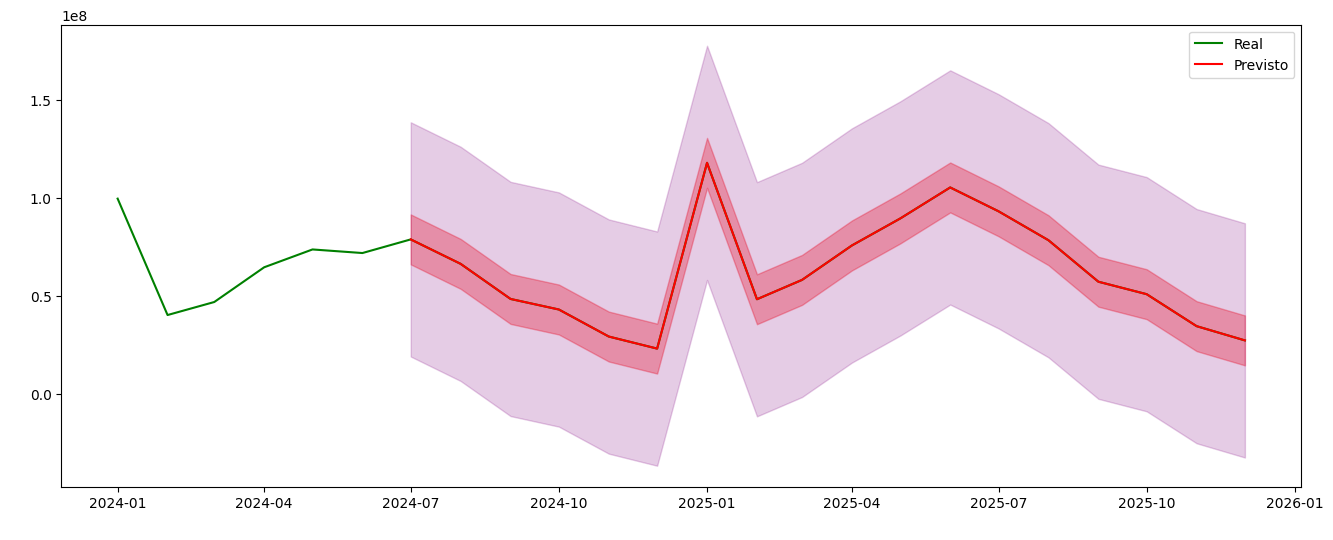

In [ ]:
plt.figure(figsize = (16,6))
plt.ylabel(' ')
plt.xlabel(' ')
sns.lineplot(x = predval_wh_mm.loc[predval_wh_mm.index >= '2024-01-01'].index,
             y = predval_wh_mm.loc[predval_wh_mm.index >= '2024-01-01'].IPVA,
             color = 'green',
             label = 'Real')
sns.lineplot(x = predval_wh_mm.loc[predval_wh_mm.index >= '2024-07-01'].index,
             y = predval_wh_mm.loc[predval_wh_mm.index >= '2024-07-01'].IPVA,
             color = 'red',
             label = 'Previsto')
plt.fill_between(df3_ipva.index,
                 df3_ipva['Intervalo Inferior - MM'],
                 df3_ipva['Intervalo Superior - MM'],
                 alpha = 0.3,
                 color = 'Red')
plt.fill_between(pred_wh_mm.index,
                 pred_wh_mm['Intervalo Inferior de Previsão'],
                 pred_wh_mm['Intervalo Superior de Previsão'],
                 alpha = 0.2,
                 color = 'Purple')

In [240]:
prev_icms

Previsão Modelo 1         error  conf_interval  pred_interval  \
2022-09-01       4.673349e+08 -1.567586e+07   3.364391e+07   1.387174e+08   
2022-10-01       4.956640e+08 -4.219143e+06   3.364391e+07   1.387174e+08   
2022-11-01       5.174248e+08 -1.666739e+07   3.364391e+07   1.387174e+08   
2022-12-01       5.663836e+08 -4.867763e+07   3.364391e+07   1.387174e+08   
2023-01-01       5.488806e+08 -2.979401e+07   3.364391e+07   1.387174e+08   
2023-02-01       5.090255e+08 -1.757461e+07   3.364391e+07   1.387174e+08   
2023-03-01       4.681865e+08  2.385181e+07   3.364391e+07   1.387174e+08   
2023-04-01       5.012768e+08  2.277357e+07   3.364391e+07   1.387174e+08   
2023-05-01       4.769867e+08  5.999945e+07   3.364391e+07   1.387174e+08   
2023-06-01       4.930216e+08  6.099345e+07   3.364391e+07   1.387174e+08   
2023-07-01       4.798556e+08  7.253196e+07   3.364391e+07   1.387174e+08   
2023-08-01       4.934175e+08  6.443819e+07   3.364391e+07   1.387174e+08   
2023-09-01       5.003808e+08  6.386797e+07   3.364391e+07   1.387174e+08   
2023-10-01       5.287066e+08  5.782219e+07   3.364391e+07   1.387174e+08   
2023-11-01       5.504643e+08  7.306399e+07   3.364391e+07   1.387174e+08   
2023-12-01       5.994199e+08  2.150925e+08   3.364391e+07   1.387174e+08   

              conf_lower    conf_upper    pred_lower    pred_upper  
2022-09-01  4.336910e+08  5.009788e+08  3.286175e+08  6.060523e+08  
2022-10-01  4.620201e+08  5.293079e+08  3.569466e+08  6.343814e+08  
2022-11-01  4.837809e+08  5.510687e+08  3.787074e+08  6.561422e+08  
2022-12-01  5.327397e+08  6.000275e+08  4.276662e+08  7.051010e+08  
2023-01-01  5.152367e+08  5.825245e+08  4.101632e+08  6.875980e+08  
2023-02-01  4.753816e+08  5.426694e+08  3.703081e+08  6.477429e+08  
2023-03-01  4.345426e+08  5.018304e+08  3.294691e+08  6.069039e+08  
2023-04-01  4.676329e+08  5.349207e+08  3.625594e+08  6.399942e+08  
2023-05-01  4.433428e+08  5.106307e+08  3.382693e+08  6.157041e+08  
2023-06-01  4.593777e+08  5.266655e+08  3.543042e+08  6.317390e+08  
2023-07-01  4.462117e+08  5.134995e+08  3.411382e+08  6.185730e+08  
2023-08-01  4.597736e+08  5.270614e+08  3.547001e+08  6.321349e+08  
2023-09-01  4.667368e+08  5.340247e+08  3.616634e+08  6.390982e+08  
2023-10-01  4.950627e+08  5.623506e+08  3.899892e+08  6.674241e+08  
2023-11-01  5.168204e+08  5.841083e+08  4.117469e+08  6.891817e+08  
2023-12-01  5.657760e+08  6.330639e+08  4.607025e+08  7.381374e+08

# Teste com critério de erro acumulado

In [285]:
# Definir a função para calcular o MAPE
def calculate_mape(true_values, predictions):
    return round(MAPE(true_values, predictions)*100,2)

# Definir os parâmetros a serem testados
p = d = q = range(0, 2)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_period = [12]

# Gerar todas as combinações possíveis de parâmetros
pdq_combinations = list(product(p, d, q))
seasonal_pdq_combinations = [(x[0], x[1], x[2], sp) for x in product(seasonal_p, seasonal_d, seasonal_q) for sp in seasonal_period]


# Inicializar listas para armazenar resultados
mape = []
order1 = []
seasonal_order1 = []

# Iterar sobre todas as combinações de parâmetros
for pdq in pdq_combinations:
    for seasonal_pdq in seasonal_pdq_combinations:
        try:
            # Ajustar o modelo SARIMA
            model = pm.ARIMA(order=pdq, seasonal_order=seasonal_pdq, suppress_warnings=True)
            model_fit = model.fit(df_treino['ICMS'])

            # Realizar previsões
            pred = model_fit.predict(n_periods=16)

            # Calcular o MAPE
            error = calculate_mape(df_treino['ICMS'][-16:], pred)

            # Armazenar os resultados
            order1.append(pdq)
            seasonal_order1.append(seasonal_pdq)
            mape.append(error)
        except Exception as e:
            continue

# Criar um DataFrame com os resultados
result_icms = pd.DataFrame({
    'order': order1,
    'seasonal_order': seasonal_order1,
    'MAPE': mape
})

# Exibir o DataFrame ordenado pelo MAPE
result_icms = result_icms.sort_values(by='MAPE')
result_icms

order seasonal_order   MAPE
24  (0, 1, 1)  (0, 0, 0, 12)   7.62
25  (0, 1, 1)  (0, 0, 1, 12)   7.63
20  (0, 1, 0)  (1, 0, 0, 12)   7.64
17  (0, 1, 0)  (0, 0, 1, 12)   7.73
49  (1, 1, 0)  (0, 0, 1, 12)   7.73
..        ...            ...    ...
9   (0, 0, 1)  (0, 0, 1, 12)  26.75
12  (0, 0, 1)  (1, 0, 0, 12)  30.58
4   (0, 0, 0)  (1, 0, 0, 12)  32.05
8   (0, 0, 1)  (0, 0, 0, 12)  38.69
0   (0, 0, 0)  (0, 0, 0, 12)  40.72

[64 rows x 3 columns]

In [286]:
# Definir a função para calcular o MAPE
def calculate_mape(true_values, predictions):
    return round(MAPE(true_values, predictions)*100,2)

# Definir os parâmetros a serem testados
p = d = q = range(0, 2)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_period = [12]

# Gerar todas as combinações possíveis de parâmetros
pdq_combinations = list(product(p, d, q))
seasonal_pdq_combinations = [(x[0], x[1], x[2], sp) for x in product(seasonal_p, seasonal_d, seasonal_q) for sp in seasonal_period]


# Inicializar listas para armazenar resultados
mape = []
order1 = []
seasonal_order1 = []

# Iterar sobre todas as combinações de parâmetros
for pdq in pdq_combinations:
    for seasonal_pdq in seasonal_pdq_combinations:
        try:
            # Ajustar o modelo SARIMA
            model = pm.ARIMA(order=pdq, seasonal_order=seasonal_pdq, suppress_warnings=True)
            model_fit = model.fit(df_treino['IPVA'])

            # Realizar previsões
            pred = model_fit.predict(n_periods=16)

            # Calcular o MAPE
            error = calculate_mape(df_treino['IPVA'][-16:], pred)

            # Armazenar os resultados
            order1.append(pdq)
            seasonal_order1.append(seasonal_pdq)
            mape.append(error)
        except Exception as e:
            continue

# Criar um DataFrame com os resultados
result_icms = pd.DataFrame({
    'order': order1,
    'seasonal_order': seasonal_order1,
    'MAPE': mape
})

# Exibir o DataFrame ordenado pelo MAPE
result_ipva = result_icms.sort_values(by='MAPE')
result_ipva

order seasonal_order   MAPE
32  (1, 0, 0)  (0, 0, 0, 12)  44.57
40  (1, 0, 1)  (0, 0, 0, 12)  45.19
8   (0, 0, 1)  (0, 0, 0, 12)  49.35
0   (0, 0, 0)  (0, 0, 0, 12)  50.59
33  (1, 0, 0)  (0, 0, 1, 12)  55.35
..        ...            ...    ...
23  (0, 1, 0)  (1, 1, 1, 12)  94.26
22  (0, 1, 0)  (1, 1, 0, 12)  94.27
19  (0, 1, 0)  (0, 1, 1, 12)  94.33
50  (1, 1, 0)  (0, 1, 0, 12)  94.42
18  (0, 1, 0)  (0, 1, 0, 12)  95.37

[64 rows x 3 columns]

In [ ]:
result_icms.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/SARIMA/resultado_AUTOMAPE_ICMS.xlsx')
result_ipva.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/SARIMA/resultado_AUTOMAPE_IPVA.xlsx')

# Construção da tabela de resultados

In [266]:
# Tabela com os dois impostos e métricas
imp_e_mod = {'ICMS': [prev_icms, sarima_icms, 0], 'IPVA': [prev_ipva, sarima_ipva, 1]}
data_ini_prev = '2022-09-01'
df_real_prov = df_real.loc[(df_real.index >= data_ini_prev) & (df_real.index <= '2023-12-01')]
df_error = pd.DataFrame(index=['ICMS', 'IPVA'],
                        columns=['MAPE', 'MAE', 'RMSE', 'AIC', 'BIC', 'AICc'])

for imp, mod in imp_e_mod.items():

  df_error.iloc[mod[2], 0] = round(MAPE(df_real[imp],
                                      mod[0].loc[(mod[0].index >= data_ini_prev)]['Previsão Modelo 1'])*100,
                                2)
  df_error.iloc[mod[2], 1] = round(MAE(df_real[imp],
                                    mod[0].loc[(mod[0].index >= data_ini_prev)]['Previsão Modelo 1']),
                                2)
  df_error.iloc[mod[2], 2] = round(MSE(df_real[imp],
                                    mod[0].loc[(mod[0].index >= data_ini_prev)]['Previsão Modelo 1'],
                                    squared=False),2)
  df_error.iloc[mod[2], 3] = round(mod[1].aic(),2)
  df_error.iloc[mod[2], 4] = round(mod[1].bic(),2)
  df_error.iloc[mod[2], 5] = round(mod[1].aicc(),2)

df_error.sort_values(by='MAPE', inplace=True)
df_error_icms = df_error
df_error_icms

MAPE          MAE         RMSE      AIC      BIC     AICc
ICMS   8.86  52940233.21  71130997.55   6075.2  6087.57  6075.43
IPVA  24.21   7395729.49   8811600.24  5607.74  5620.12  5607.98

In [268]:
'''df_error_icms.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/SARIMA/tabela_de_resultados.xlsx')'''

# Visualizações finais

## Formatando para Times new Roman

In [229]:
# Fontes disponíveis
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [230]:
# Adicionando Times new Roman
font_dirs = ["/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Fontes"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [231]:
# Fontes disponíveis
def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [232]:
# Definindo timew new roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

In [233]:
# Definindo o DPI das imagens
dpi = 800
mpl.rcParams['figure.dpi'] = dpi
mpl.rcParams['savefig.dpi'] = dpi

## ACF E PACF

In [92]:
df_icms_dif = df_icms_dif.dropna()
df_ipva_dif = df_ipva_dif.dropna()
df_icms_dif_ns = df_icms_dif_ns.dropna()
df_ipva_dif_ns = df_ipva_dif_ns.dropna()

In [234]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(ncols=2, nrows=4, sharex=False, figsize=(16,10))

# shift 1

plot_acf(df_icms_dif, ax=ax1, lags=87)
plot_pacf(df_icms_dif, ax=ax2, lags = 87)
plot_acf(df_ipva_dif, ax=ax3, lags=87)
plot_pacf(df_ipva_dif, ax=ax4, lags=87)

# shift 12

plot_acf(df_icms_dif_ns, ax=ax5, lags=81)
plot_pacf(df_icms_dif_ns, ax=ax6, lags = 81)
plot_acf(df_ipva_dif_ns, ax=ax7, lags=81)
plot_pacf(df_ipva_dif_ns, ax=ax8, lags=81)

for i in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8):
  i.grid(axis='x')

for i in (ax1, ax3, ax5, ax7):
  i.set_title('Autocorrelação (FAC)', fontsize=20)

for i in (ax2, ax4, ax6, ax8):
  i.set_title('Autocorrelação Parcial (FACP)', fontsize=20)


plt.tight_layout()
fig.text(0.5, 1, 'ICMS - Primeira diferença', horizontalalignment='center', verticalalignment='center', fontsize=20)
fig.text(0.5, 0.75, 'IPVA - Primeira diferença', horizontalalignment='center', verticalalignment='center', fontsize=20)
fig.text(0.5, 0.49, 'ICMS - Diferenciação Sazonal', horizontalalignment='center', verticalalignment='center', fontsize=20)
fig.text(0.5, 0.24, 'IPVA - Diferenciação Sazonal', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.subplots_adjust(hspace=0.8)
#plt.savefig('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/SARIMA/ACF_PACF_1DIF_DIFSAZON.png', transparent=True, dpi=dpi)
plt.show();

## Previsões - Análise B-J

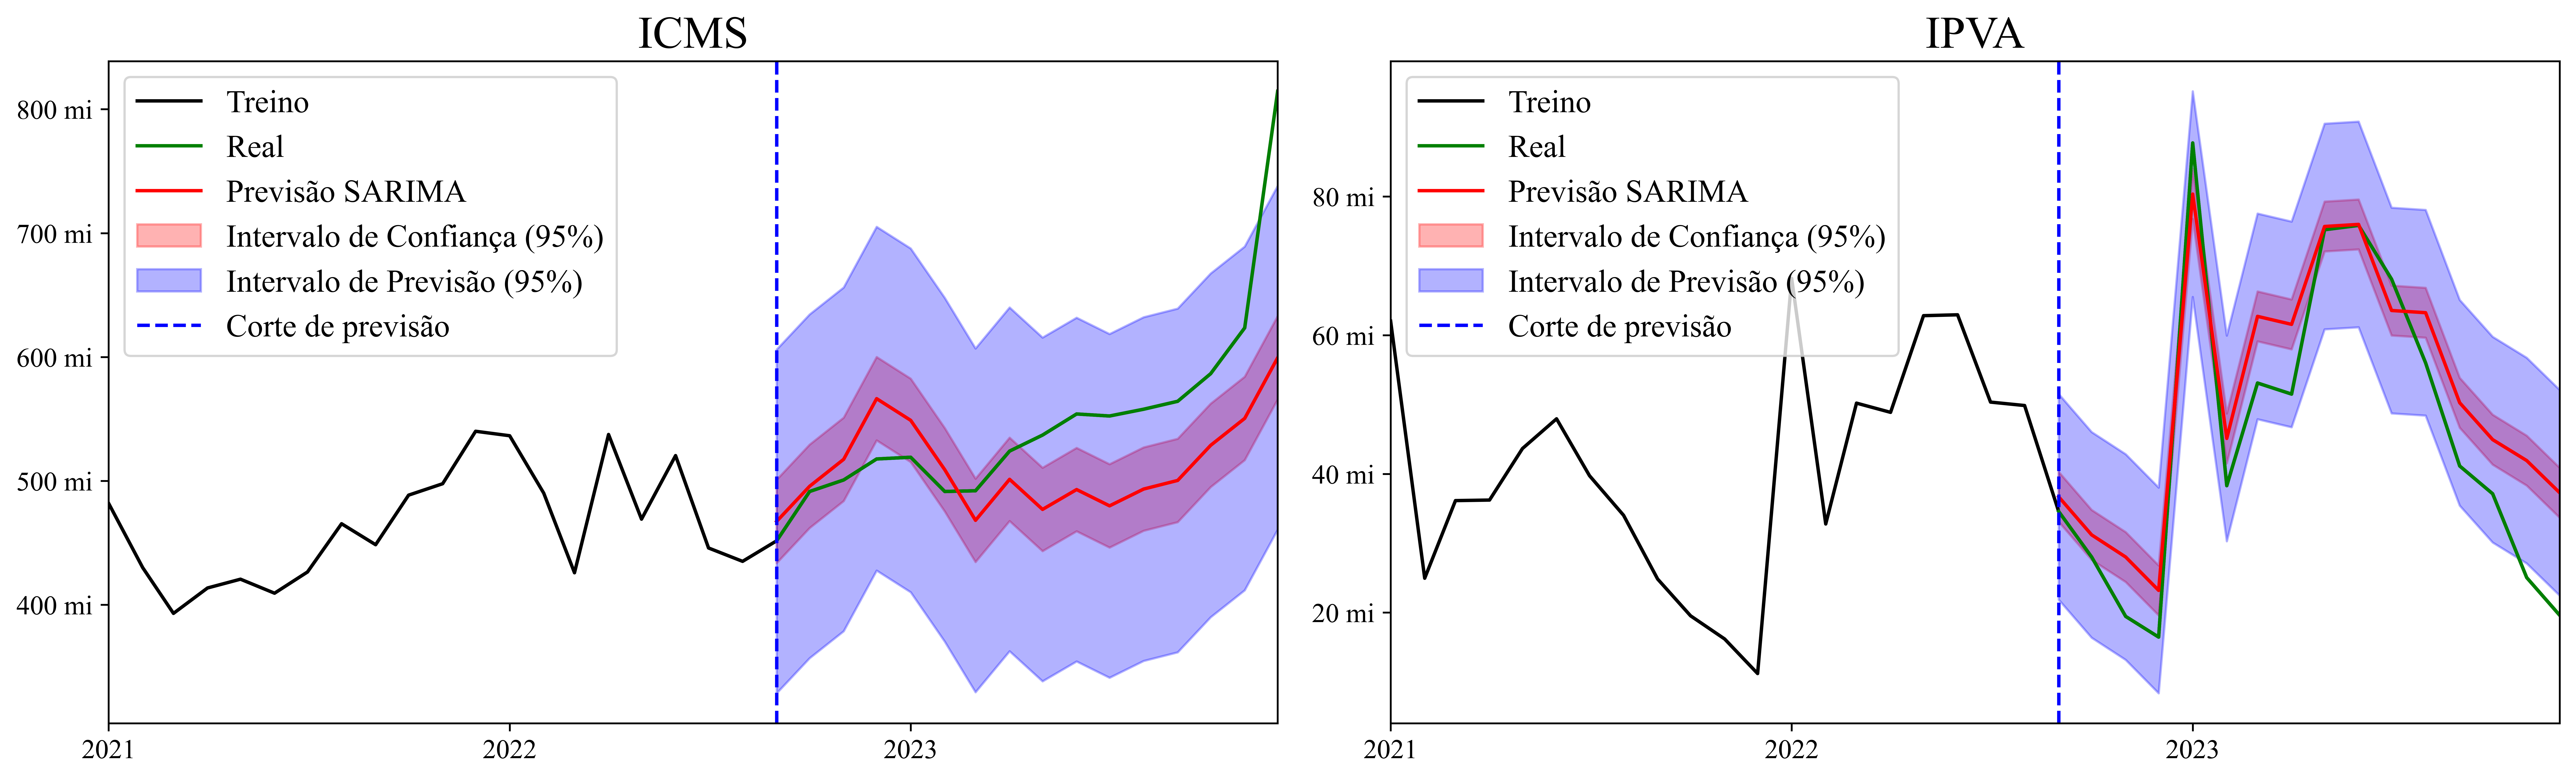

In [236]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Base de dados para os graficos
ini_treino = '2021-01-01'
fim_treino = '2022-08-01'
ini_prev = '2022-09-01'
fim_prev = '2023-12-01'
imp_ax = {'ICMS': [ax1, prev_icms], 'IPVA': [ax2, prev_ipva]}

for imp, axs in imp_ax.items():
  # Treino
  sns.lineplot(x=df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index,
               y=df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)][imp],
               label='Treino',
               color='black',
               ax=axs[0])
  # Real
  sns.lineplot(x=df.loc[(df.index >= ini_prev) & (df.index <= fim_prev)].index,
               y=df.loc[(df.index >= ini_prev) & (df.index <= fim_prev)][imp],
               label='Real',
               color='green',
               ax=axs[0])
  # Previsão
  sns.lineplot(x=axs[1].loc[(axs[1].index >= ini_prev) & (axs[1].index <= fim_prev)].index,
               y=axs[1].loc[(axs[1].index >= ini_prev) & (axs[1].index <= fim_prev)]['Previsão Modelo 1'],
               label='Previsão SARIMA',
               color='red',
               ax=axs[0])
  # Intervalo de Confiança
  axs[0].fill_between(axs[1].index,
                   axs[1]['conf_lower'],
                   axs[1]['conf_upper'],
                   color='red',
                   alpha=0.3,
                   label='Intervalo de Confiança (95%)')
  # Intervalo de Previsão
  axs[0].fill_between(axs[1].index,
                   axs[1]['pred_lower'],
                   axs[1]['pred_upper'],
                   color='blue',
                   alpha=0.3,
                   label='Intervalo de Previsão (95%)')

# Formatação
def formatar_milhares(x, pos):
  return f'{x/1000000:.0f} mi'
formatter = mticker.FuncFormatter(formatar_milhares)
year_locator = YearLocator(base=1)

for ax in (ax1, ax2):
  ax.xaxis.set_major_locator(year_locator)
  ax.yaxis.set_major_formatter(formatter)
  ax.set_xlabel('')
  ax.set_ylabel('')
  #ax.spines['top'].set_visible(False)
  #ax.spines['right'].set_visible(False)
  ax.set_xlim(min(df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index), max(df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index))
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)
  ax.axvline(x=pd.to_datetime('2022-09-01'), color='blue', linestyle='--', label='Corte de previsão')
  ax.legend(loc='upper left')
ax1.set_title('ICMS', fontdict={'fontsize': 20})
ax2.set_title('IPVA', fontdict={'fontsize': 20})
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/SARIMA/graf_previsoes_SARIMA.png', transparent=True, dpi=dpi)
plt.show()

In [237]:
'''prev_ipva.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/SARIMA/previsoes_sarima_IPVA.xlsx')
prev_icms.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/SARIMA/previsoes_sarima_ICMS.xlsx')'''

## Previsões - AutoARIMA

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Base de dados para os graficos
ini_treino = '2021-01-01'
fim_treino = '2022-08-01'
ini_prev = '2022-09-01'
fim_prev = '2023-12-01'
imp_ax = {'ICMS': [ax1, prev_icms], 'IPVA': [ax2, prev_ipva]}

for imp, axs in imp_ax.items():
  # Treino
  sns.lineplot(x=df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index,
               y=df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)][imp],
               label='Treino',
               color='black',
               ax=axs[0])
  # Real
  sns.lineplot(x=df.loc[(df.index >= ini_prev) & (df.index <= fim_prev)].index,
               y=df.loc[(df.index >= ini_prev) & (df.index <= fim_prev)][imp],
               label='Real',
               color='green',
               ax=axs[0])
  # Previsão
  sns.lineplot(x=axs[1].loc[(axs[1].index >= ini_prev) & (axs[1].index <= fim_prev)].index,
               y=axs[1].loc[(axs[1].index >= ini_prev) & (axs[1].index <= fim_prev)]['Previsão Modelo 1'],
               label='Previsão SARIMA',
               color='red',
               ax=axs[0])
  # Intervalo de Confiança
  axs[0].fill_between(axs[1].index,
                   axs[1]['conf_lower'],
                   axs[1]['conf_upper'],
                   color='red',
                   alpha=0.3,
                   label='Intervalo de Confiança (95%)')
  # Intervalo de Previsão
  axs[0].fill_between(axs[1].index,
                   axs[1]['pred_lower'],
                   axs[1]['pred_upper'],
                   color='blue',
                   alpha=0.3,
                   label='Intervalo de Previsão (95%)')

# Formatação
def formatar_milhares(x, pos):
  return f'{x/1000000:.0f} mi'
formatter = mticker.FuncFormatter(formatar_milhares)
year_locator = YearLocator(base=1)

for ax in (ax1, ax2):
  ax.xaxis.set_major_locator(year_locator)
  ax.yaxis.set_major_formatter(formatter)
  ax.set_xlabel('')
  ax.set_ylabel('')
  #ax.spines['top'].set_visible(False)
  #ax.spines['right'].set_visible(False)
  ax.set_xlim(min(df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index), max(df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index))
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)
  ax.axvline(x=pd.to_datetime('2022-09-01'), color='blue', linestyle='--', label='Corte de previsão')
  ax.legend(loc='upper left')
ax1.set_title('ICMS', fontdict={'fontsize': 20})
ax2.set_title('IPVA', fontdict={'fontsize': 20})
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/Holt-Winters/graf_previsoes_SARIMA.png', transparent=True, dpi=dpi)
plt.show()